# Multi-Armed Bandit for Data Selection

We follow in the footsteps of Gutiérrez et al (2017). Let us first formulate our objective mathematically.

#### Modelling Objective

We want to model $f: (x, \mathbf{p}) \mapsto y$, where $f$ belongs to the class of linear regression estimators parameterized by vector $\mathbf{p}$. $x_i$  and $y_i$ are the RH98 and AGBD of footprint $i$, respectively. 

Parameters $\mathbf{p}$ are estimated using a training set $S^T = \{ s_1, \ldots, s_{N_{\text{train}}} \}$ consisting of samples $s = (x,y)$. However, $S^T$ is merely a subsample from the available training data $S = \{ h_1, \ldots, h_{N_{\text{total}}} \} $ which consists of _hidden_ samples of the form $h = \{ \tilde{x}, \tilde{y}, \mathbf{m} \}$. They are hidden because RH98 $\tilde{x}$ and AGBD $\tilde{y}$ are only revealed after the sample is added to the training set. By contrast, metadata $\mathbf{m}$ about the sample is known à priori. To begin with, $S$ consists of all data in Ghana with PFT class = 2. 

#### Sample Efficiency Objective

Unlike Gutiérrez et al, we do not incur a large cost from observing $\tilde{x}$ or $\tilde{y}$. However, we are interested in selecting only the most relevant samples according to $\mathbf{m}$ all the same. We will later generalise our method to larger, more complicated datasets and more sophisticated model classes, hence sample efficiency will be important to minimise the computational burden of training the model.

We select samples by partitioning $S$ into a pre-defined number of bins $\eta_j$ for select $m_j$ $(1 \leq j \leq d)$ in $\mathbf{m}$. For instance, if $m_j$ is a categorical variable with four categories, we create the j'th partition $S = \bigcup_{k=1}^{4} C_k^j$, where $C_1^j$ contains all samples where $m_j$ is in class 1, $C_2^j$ contains all samples where $m_j$ is in class 2, etc. If $m_j$ is continuous, we quantize the variable into bins and partition accordingly. All the clusters generated using different meta information are then merged into a set of clusters $\mathcal{C} = \{C_l^j\}$. Our hypothesis is that some clusters $C_i \in \mathcal{C}$ contain more relevant information for the modelling task than others, but we do not know which. This motivates us to train a multi-armed bandit who will simultaneously _explore_ the clusters to find out which contain the most relevant information and eventually _exploit_ these clusters to maximise the share of data therefrom.

The multi-armed bandit algorithm is described in detail in their paper, but to summarise:

* At every time $t$:
    * Sample the probability of reward $\hat{\pi}_i$ from $Beta(\alpha_i, \beta_i)$ for every cluster
    * Pick a datapoint $s$ from the cluster with highest probability of reward
    * Add $s$ to $S^T$ and re-train the model
    * Predict $\hat{y}$ for a holdout validation set
    * If score increases (decreases), $r_t = 1 \ (-1)$
    * Update $\alpha_i, \beta_i$ based on $r_t$ 

#### Summary of Objective

Our dual objectives are then:

1) To optimize the performance of $f$ at predicting $y$, as measured by the MAPE on a holdout test set.
2) To include as few samples as necessary in $S^T$.

We will train a multi-armed bandit data selector to achieve both in parallel.

### Load Packages and Data

In [1]:
import importlib
import pandas as pd
import geopandas as gpd
import pyogrio
import os
import pandas.api.types as ptypes
import numpy as np
import warnings
import pickle as pkl
import types
import statsmodels.api as sm
import folium
import torch
import contextlib
import random
import warnings
from torch import nn
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, PoissonRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, explained_variance_score, mean_squared_error # , root_mean_squared_error
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
from scipy.stats import beta
from scipy.spatial.distance import euclidean, cdist
from custom_ttv_split import load_data, get_ttv_indices
from benchmarking_utils import *
from pandas.errors import SettingWithCopyWarning 

# import robust method to benchmark
from robust_regression import Torrent

# import bandit(s)
from MACES import bandit, crafty_bandit, lazy_bandit, ND_bandit

# import score functions
from custom_score_functions import log_ratio, LogRatioLoss

# import custom models
from custom_models import *

# import LL coreset selector
from ll_coreset_selector import LL_coreset_selector

# function to assess stability of model
from Debugging.stable_train_utils import assess_stability, MLP_test, compare_lr

# KCG
from k_center_greedy import k_center_greedy

# metadata dist selector
from metadata_dists import metadata_dist_selector

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

os.chdir(r"C:\Users\nial\OneDrive\ETH Zürich\Master Thesis")

# PREDICTING AGBD FROM SATELLITE BAND DATA

Now we try a `lazy_bandit()` with `df_global`

In [2]:
df_global               = load_data()
df_global_subset        = df_global #.sample(1000, ignore_index=False)

hidden_indices, test_indices, val_indices\
                        =  get_ttv_indices(df_global_subset, 'new_colour')

# features
x                       = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"]
y                       = 'agbd'
features                = {'region_cla':None, 'elev_lowes':3, 'selected_a': None}

# MABS parameters
T                       = 4000
batch_size              = 10
test_freq               = 10
score                   = mean_squared_error

# MLP parameters
n_predictors            = len(x)
num_epochs              = 5
lr                      = 0.01
with_scheduler          = False
loss_fn                 = nn.MSELoss()

# model
model                   = MLP(n_predictors=n_predictors, num_epochs=num_epochs, lr=lr, with_scheduler=with_scheduler, loss_fn=loss_fn) 
# model                   = PoissonRegressor()

# agent
bandit_global           = lazy_bandit(dataset=df_global_subset, x=x, y=y, features=features, hidden_indices=hidden_indices
                                      , test_indices=test_indices, val_indices=val_indices, T=T, batch_size=batch_size
                                      , test_freq=test_freq, model=model)

bandit_global.score     = score

In [3]:
compare_lr(bandit_global)

MLP model reinitialised
Benchmarking run 1 for model full
MLP model reinitialised
Model fit 1. Epoch [1/5], Training loss: 7579.4027, lr: 0.01
Model fit 1. Epoch [2/5], Training loss: 6745.5992, lr: 0.01
Model fit 1. Epoch [3/5], Training loss: 6572.1853, lr: 0.01
Model fit 1. Epoch [4/5], Training loss: 6482.9277, lr: 0.01
Model fit 1. Epoch [5/5], Training loss: 6407.0731, lr: 0.01
Benchmarking run 2 for model full
MLP model reinitialised
Model fit 1. Epoch [1/5], Training loss: 7567.0358, lr: 0.01
Model fit 1. Epoch [2/5], Training loss: 6871.4383, lr: 0.01
Model fit 1. Epoch [3/5], Training loss: 6589.1697, lr: 0.01
Model fit 1. Epoch [4/5], Training loss: 6450.3383, lr: 0.01
Model fit 1. Epoch [5/5], Training loss: 6373.3865, lr: 0.01
Benchmarking run 3 for model full
MLP model reinitialised
Model fit 1. Epoch [1/5], Training loss: 7441.5248, lr: 0.01
Model fit 1. Epoch [2/5], Training loss: 6754.6076, lr: 0.01
Model fit 1. Epoch [3/5], Training loss: 6560.8015, lr: 0.01
Model fit

{0.01: array([9207.28270641, 9207.28270641, 9207.28270641, 9207.28270641,
        9207.28270641, 9207.28270641, 9207.28270641, 9207.28270641,
        9207.28270641, 9207.28270641, 9207.28270641, 9207.28270641,
        9207.28270641, 9207.28270641, 9207.28270641, 9207.28270641,
        9207.28270641, 9207.28270641, 9207.28270641, 9207.28270641,
        9207.28270641, 9207.28270641, 9207.28270641, 9207.28270641,
        9207.28270641, 9207.28270641, 9207.28270641, 9207.28270641,
        9207.28270641, 9207.28270641, 9207.28270641, 9207.28270641,
        9207.28270641, 9207.28270641, 9207.28270641, 9207.28270641,
        9207.28270641, 9207.28270641, 9207.28270641, 9207.28270641]),
 0.001: array([8761.83521429, 8761.83521429, 8761.83521429, 8761.83521429,
        8761.83521429, 8761.83521429, 8761.83521429, 8761.83521429,
        8761.83521429, 8761.83521429, 8761.83521429, 8761.83521429,
        8761.83521429, 8761.83521429, 8761.83521429, 8761.83521429,
        8761.83521429, 8761.83521

In [3]:
KCG_test_scores(bandit_global, 10)

Model fit 1. Epoch [1/5], Training loss: 25365.2334, lr: 0.01
Model fit 1. Epoch [2/5], Training loss: 21755.8518, lr: 0.01
Model fit 1. Epoch [3/5], Training loss: 28408.0286, lr: 0.01
Model fit 1. Epoch [4/5], Training loss: 20751.7970, lr: 0.01
Model fit 1. Epoch [5/5], Training loss: 20079.3874, lr: 0.01
Model fit 11. Epoch [1/5], Training loss: 22603.2184, lr: 0.01
Model fit 11. Epoch [2/5], Training loss: 17150.2453, lr: 0.01
Model fit 11. Epoch [3/5], Training loss: 14994.5614, lr: 0.01
Model fit 11. Epoch [4/5], Training loss: 12311.7778, lr: 0.01
Model fit 11. Epoch [5/5], Training loss: 9989.8299, lr: 0.01
Model fit 21. Epoch [1/5], Training loss: 19822.0455, lr: 0.01
Model fit 21. Epoch [2/5], Training loss: 13859.8705, lr: 0.01
Model fit 21. Epoch [3/5], Training loss: 9811.6831, lr: 0.01
Model fit 21. Epoch [4/5], Training loss: 9118.5206, lr: 0.01
Model fit 21. Epoch [5/5], Training loss: 8859.3732, lr: 0.01
Model fit 31. Epoch [1/5], Training loss: 17511.5016, lr: 0.01
M

Benchmarking run 1 for model full
MLP model reinitialised
Model fit 1. Epoch [1/5], Training loss: 12800.0144, lr: 0.0001
Model fit 1. Epoch [2/5], Training loss: 8120.9764, lr: 0.0001
Model fit 1. Epoch [3/5], Training loss: 8014.6256, lr: 0.0001
Model fit 1. Epoch [4/5], Training loss: 7953.6785, lr: 0.0001
Model fit 1. Epoch [5/5], Training loss: 7910.3518, lr: 0.0001
Benchmarking run 2 for model full
MLP model reinitialised
Model fit 1. Epoch [1/5], Training loss: 13708.3993, lr: 0.0001
Model fit 1. Epoch [2/5], Training loss: 8155.9020, lr: 0.0001
Model fit 1. Epoch [3/5], Training loss: 8031.9318, lr: 0.0001
Model fit 1. Epoch [4/5], Training loss: 7966.1778, lr: 0.0001
Model fit 1. Epoch [5/5], Training loss: 7912.8773, lr: 0.0001
Benchmarking run 3 for model full
MLP model reinitialised
Model fit 1. Epoch [1/5], Training loss: 12253.0703, lr: 0.0001
Model fit 1. Epoch [2/5], Training loss: 8081.6466, lr: 0.0001
Model fit 1. Epoch [3/5], Training loss: 7984.2283, lr: 0.0001
Mode

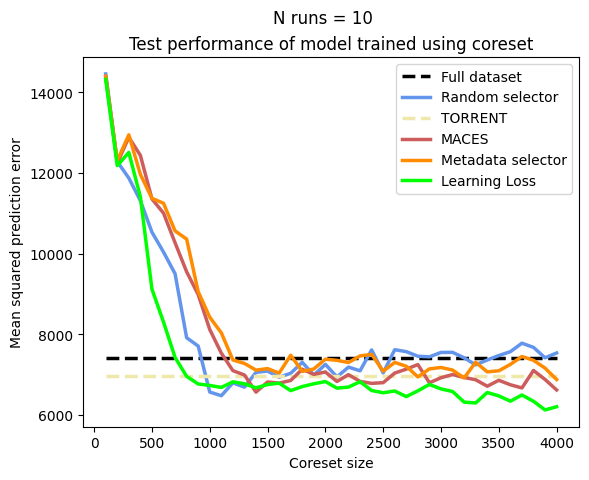

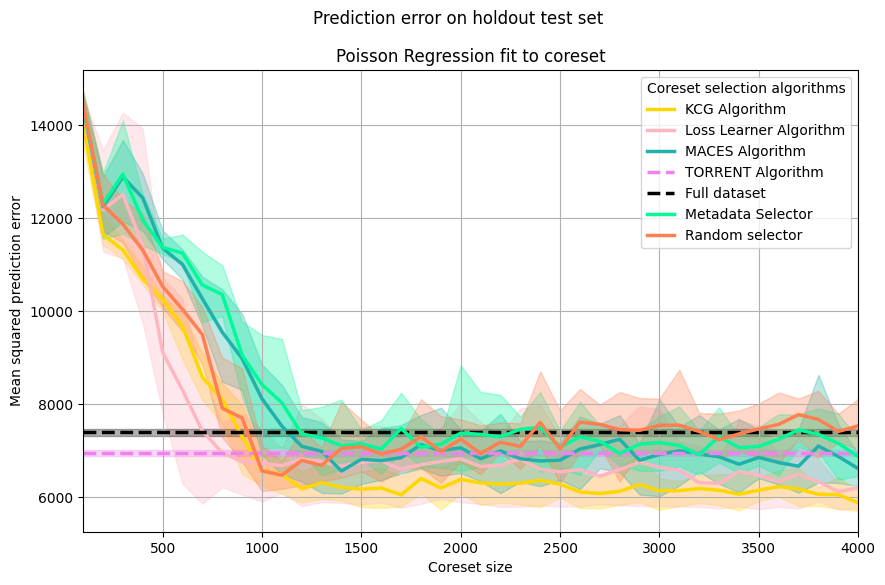

In [2]:
os.chdir(r"C:\Users\nial\Documents\GitHub\Master-Thesis")
%run results-MLP.py

In [4]:
with open(r'C:\Users\nial\Documents\GitHub\Master-Thesis\Comprehensive Benchmarks\mlp-bmk\mlp-bmk_tbl.pkl', 'rb') as f:
    mlp_bmk_tbl = pkl.load(f)

mlp_bmk_tbl

,which,current_run,test_time_100,test_time_200,test_time_300,test_time_400,test_time_500,test_time_600,test_time_700,test_time_800,...,test_time_3100,test_time_3200,test_time_3300,test_time_3400,test_time_3500,test_time_3600,test_time_3700,test_time_3800,test_time_3900,test_time_4000
0,full,1,7460.151299,7460.151299,7460.151299,7460.151299,7460.151299,7460.151299,7460.151299,7460.151299,...,7460.151299,7460.151299,7460.151299,7460.151299,7460.151299,7460.151299,7460.151299,7460.151299,7460.151299,7460.151299
1,full,2,7374.587007,7374.587007,7374.587007,7374.587007,7374.587007,7374.587007,7374.587007,7374.587007,...,7374.587007,7374.587007,7374.587007,7374.587007,7374.587007,7374.587007,7374.587007,7374.587007,7374.587007,7374.587007
2,full,3,7360.807477,7360.807477,7360.807477,7360.807477,7360.807477,7360.807477,7360.807477,7360.807477,...,7360.807477,7360.807477,7360.807477,7360.807477,7360.807477,7360.807477,7360.807477,7360.807477,7360.807477,7360.807477
3,full,4,7306.784268,7306.784268,7306.784268,7306.784268,7306.784268,7306.784268,7306.784268,7306.784268,...,7306.784268,7306.784268,7306.784268,7306.784268,7306.784268,7306.784268,7306.784268,7306.784268,7306.784268,7306.784268
4,full,5,7436.309565,7436.309565,7436.309565,7436.309565,7436.309565,7436.309565,7436.309565,7436.309565,...,7436.309565,7436.309565,7436.309565,7436.309565,7436.309565,7436.309565,7436.309565,7436.309565,7436.309565,7436.309565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,KCG,6,13565.859464,11430.431239,11543.555106,10993.850421,10595.607814,9895.945104,8679.891677,7915.573350,...,6581.452498,5989.299544,6021.172629,6567.269341,6198.057361,6734.987567,6625.679796,6211.563404,5987.242966,6152.283943
66,KCG,7,13727.154796,11938.731506,11119.219891,10748.023525,10192.315687,9950.003065,9034.644309,8438.975234,...,5753.277297,5870.785646,5896.307806,5716.847129,5917.713404,6291.624795,5746.663140,6076.613513,6141.166617,6014.493303
67,KCG,8,14079.142850,12087.526399,11421.045166,10601.989935,10304.394534,9910.154068,8555.589139,6989.007347,...,6347.071868,7059.694332,6225.368344,5908.138188,5996.526401,6572.558803,6294.008996,6583.031312,5952.527325,5845.083783
68,KCG,9,13971.050533,11764.488231,11451.221499,10629.561328,10303.661239,9832.297002,8093.606006,8687.200684,...,6336.485509,6221.664135,6690.717764,6466.507971,5853.067977,6155.993476,5884.456935,5702.586780,6142.079902,5809.228143


In [6]:
with open(r'C:\Users\nial\Documents\GitHub\Master-Thesis\Comprehensive Benchmarks\mlp-bmk\mlp-bmk_sampled_clusters.pkl', 'rb') as f:
    mlp_bmk_sampled_clusters = pkl.load(f)

mlp_bmk_sampled_clusters

,cluster,count,cluster_description,proportion in coresets,proportion in hidden set
0,15,200,"{'cluster_ID_region_cla': '1.0', 'cluster_ID_e...",0.05000,0.001112
1,7,176,"{'cluster_ID_region_cla': '6.0', 'cluster_ID_e...",0.04400,0.044886
2,39,167,"{'cluster_ID_region_cla': '2.0', 'cluster_ID_e...",0.04175,0.031348
3,6,160,"{'cluster_ID_region_cla': '6.0', 'cluster_ID_e...",0.04000,0.204890
4,36,157,"{'cluster_ID_region_cla': '2.0', 'cluster_ID_e...",0.03925,0.009263
5,30,155,"{'cluster_ID_region_cla': '3.0', 'cluster_ID_e...",0.03875,0.019088
6,9,153,"{'cluster_ID_region_cla': '6.0', 'cluster_ID_e...",0.03825,0.001368
7,4,151,"{'cluster_ID_region_cla': '7.0', 'cluster_ID_e...",0.03775,0.022616
8,13,142,"{'cluster_ID_region_cla': '4.0', 'cluster_ID_e...",0.03550,0.006843
9,41,141,"{'cluster_ID_region_cla': '2.0', 'cluster_ID_e...",0.03525,0.002486


In [8]:
np.sum(mlp_bmk_sampled_clusters['count'])

4000

In [5]:
mlp_bmk_tbl[mlp_bmk_tbl['which'] == 'MACES']

,which,current_run,test_time_100,test_time_200,test_time_300,test_time_400,test_time_500,test_time_600,test_time_700,test_time_800,...,test_time_3100,test_time_3200,test_time_3300,test_time_3400,test_time_3500,test_time_3600,test_time_3700,test_time_3800,test_time_3900,test_time_4000
50,MACES,1,14327.848182,11872.577834,13365.963578,11891.169627,11239.066256,10991.345817,10217.209446,9360.293588,...,6793.975897,6643.370491,6195.420430,6505.653165,6404.811195,6880.277158,6095.825886,6268.589069,6785.984055,6153.921844
51,MACES,2,14757.382210,12647.132377,11931.380436,12191.624279,11119.313841,11126.289676,10453.450090,10500.362294,...,6574.546175,6481.800234,6961.058787,7850.184131,7290.071923,6191.960930,6536.531365,8632.027000,7584.747176,6600.493565
52,MACES,3,14075.873208,11597.353649,12800.463932,10990.485674,10351.856702,10298.956612,9013.942907,7962.029733,...,6249.995134,6808.232507,6383.586493,6492.984987,6884.410376,6311.780199,5875.457226,7307.486265,6969.084414,6490.683358
53,MACES,4,14573.903987,12895.543092,13085.868230,12183.468591,11265.840608,11326.621303,10465.944336,10295.165142,...,9303.145509,7071.952509,6921.416915,7048.892568,7450.117584,7215.722633,7462.616869,7016.396612,6683.987972,6856.612307
54,MACES,5,14212.712855,11593.729035,13976.588186,12703.821247,11367.152186,10679.984633,9678.291120,9556.974149,...,7290.078781,6693.709138,6517.815981,6105.645269,6649.717391,6939.608259,7523.208665,6314.547854,6171.626322,6931.812127
55,MACES,6,14481.653971,12752.045409,11938.530116,15429.539053,12444.794279,11979.481548,11678.166241,10468.118115,...,6897.604916,7800.345658,8115.034253,6594.525642,7066.701894,6706.551515,7386.373429,6448.058027,6951.859384,6313.927185
56,MACES,7,14429.619836,12236.136898,13616.321470,12294.009002,11734.844405,10881.444498,10002.924841,9601.826182,...,6510.200488,6550.098965,6988.815260,6206.108214,6850.302176,6275.436839,6343.221941,6562.898163,7009.751102,6923.779561
57,MACES,8,14649.156956,13121.644857,11827.583267,12955.042899,11168.808852,10844.442355,10330.436361,8975.751769,...,6024.559040,6901.502111,6861.901165,6554.212289,6596.022810,6382.286518,6129.928688,6833.440070,6723.381383,6235.177339
58,MACES,9,13868.871584,11528.059056,13681.733165,11727.568389,11608.465464,10954.193958,10741.700120,8483.500437,...,6823.560351,6545.557277,6286.252060,6043.125377,5896.263398,6429.186213,6101.583793,6352.392858,6308.409971,6324.194718
59,MACES,10,14479.622633,12199.222487,12633.915338,11984.219594,11243.755316,10951.651937,10093.517207,10280.173768,...,7508.650650,7766.509914,7453.662715,7683.620462,7462.107868,8112.378057,7198.666426,9253.718625,7574.510767,7326.478108


In [14]:
with open(r'C:\Users\nial\Documents\GitHub\Master-Thesis\Comprehensive Benchmarks\vcboost_\vcboost_.pkl', 'rb') as f:
    vcboost_ = pkl.load(f)

vcboost_[('MACES', 3)]

6156.55911016732

In [23]:
os.chdir(r"C:\Users\nial\Documents\GitHub\Master-Thesis")
%run results-metadata-in-model.py

Benchmarking run 1 for model rb
MLP model reinitialised


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

### Investigating overfitting of full model with MLP

That didn't help. What about lowering the learning rate?

We track the test loss across epochs: (64 -> 32 -> 1)

In [3]:
X, y, X_test, y_test    = bandit_global.dataset_splitter(['hidden', 'test'])

mlp_test                = MLP_test(lr=0.0001, with_scheduler=False, loss_fn=loss_fn)
mlp_test.fit(X, y, X_test, y_test)

Model fit 1. Epoch [1/5], Training loss: 10615.3229, Test loss:  7242.7900, lr: 0.0001
Model fit 1. Epoch [2/5], Training loss: 7983.6785, Test loss:  7198.8325, lr: 0.0001
Model fit 1. Epoch [3/5], Training loss: 7911.9346, Test loss:  7358.2603, lr: 0.0001
Model fit 1. Epoch [4/5], Training loss: 7858.3647, Test loss:  7397.5630, lr: 0.0001
Model fit 1. Epoch [5/5], Training loss: 7807.4827, Test loss:  7507.6851, lr: 0.0001


We track the test loss across epochs: (32 -> 16 -> 1)

In [3]:
X, y, X_test, y_test    = bandit_global.dataset_splitter(['hidden', 'test'])

mlp_test                = MLP_test(lr=0.0001, with_scheduler=False, loss_fn=loss_fn)
mlp_test.fit(X, y, X_test, y_test)

Model fit 1. Epoch [1/5], Training loss: 12274.6818, Test loss:  6987.2124, lr: 0.0001
Model fit 1. Epoch [2/5], Training loss: 8048.0254, Test loss:  7147.1548, lr: 0.0001
Model fit 1. Epoch [3/5], Training loss: 7977.8411, Test loss:  7370.1309, lr: 0.0001
Model fit 1. Epoch [4/5], Training loss: 7942.0793, Test loss:  7345.9336, lr: 0.0001
Model fit 1. Epoch [5/5], Training loss: 7910.1898, Test loss:  7430.9307, lr: 0.0001


In [5]:
with open(r'C:\Users\nial\Documents\GitHub\Master-Thesis\Comprehensive Benchmarks\KCG_runs\run_1.pkl', 'rb') as f:
    run1 = pkl.load(f)

In [10]:
4000 // 100

40

# -------------- DECOMISSIONED CODE --------------

### Comprehensive benchmark for Poisson regression

Benchmarking run 1 for model full
Benchmarking run 2 for model full
Benchmarking run 3 for model full
Benchmarking run 4 for model full
Benchmarking run 5 for model full
Benchmarking run 6 for model full
Benchmarking run 7 for model full
Benchmarking run 8 for model full
Benchmarking run 9 for model full
Benchmarking run 10 for model full
Benchmarking run 1 for model rb
Benchmarking run 2 for model rb
Benchmarking run 3 for model rb
Benchmarking run 4 for model rb
Benchmarking run 5 for model rb
Benchmarking run 6 for model rb
Benchmarking run 7 for model rb
Benchmarking run 8 for model rb
Benchmarking run 9 for model rb
Benchmarking run 10 for model rb
Benchmarking run 1 for model TORRENT
Benchmarking run 2 for model TORRENT
Benchmarking run 3 for model TORRENT
Benchmarking run 4 for model TORRENT
Benchmarking run 5 for model TORRENT
Benchmarking run 6 for model TORRENT
Benchmarking run 7 for model TORRENT
Benchmarking run 8 for model TORRENT
Benchmarking run 9 for model TORRENT
Bench

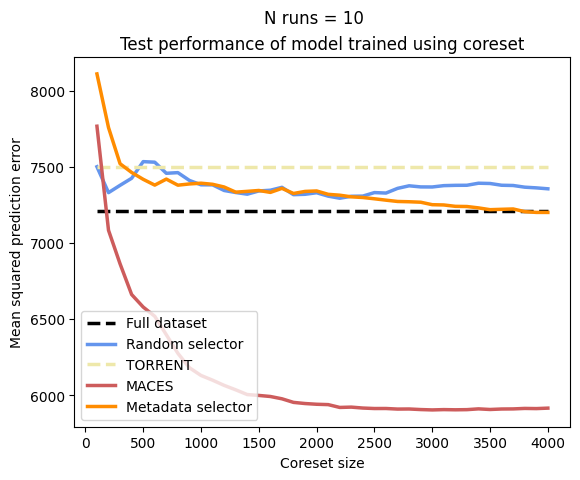

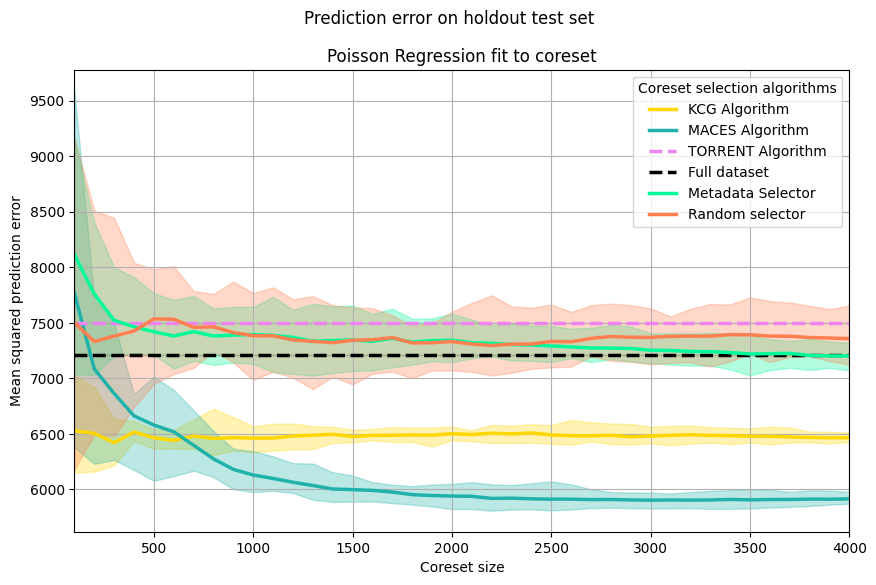

In [ ]:
os.chdir(r"C:\Users\nial\Documents\GitHub\Master-Thesis")
%run results-poisson-regression.py

### Comprehensive benchmarking for KCG

In [ ]:
df_global               = load_data()

hidden_indices, test_indices, val_indices\
                        =  get_ttv_indices(df_global, 'new_colour')

# features
x                       = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"]
y                       = 'agbd'
features                = {'region_cla':None, 'elev_lowes':3, 'selected_a': None}

# MABS parameters
T                       = 100
batch_size              = 10
test_freq               = 10

# model
model                   = PoissonRegressor()

# agent
bandit_global           = lazy_bandit(dataset=df_global, x=x, y=y, features=features, hidden_indices=hidden_indices
                                      , test_indices=test_indices, val_indices=val_indices, T=T, batch_size=batch_size
                                      , test_freq=test_freq, model=model)

####################################################################
# RUN                                                              #
####################################################################

# comprehensive_benchmark(lazy_bandit_=bandit_global, 
#                        description='Poisson Regressor Comprehensive Bmk',
#                        filename='poisson-regressor-bmk',
#                        n_runs=2
#                        )

# bandit_global.eval_test_performance(10, 'KCG')

In [ ]:
tbl = tabulate_bmk_outputs(filename='poisson-regressor-bmk', average=False, dump=True)

In [ ]:
with open(rf'C:\Users\nial\Documents\GitHub\Master-Thesis\Comprehensive Benchmarks\poisson-regressor-bmk-second\poisson-regressor-bmk-second.pkl', 'rb') as f:
    poisson_second                  = pkl.load(f)
    
with open(rf'C:\Users\nial\Documents\GitHub\Master-Thesis\Comprehensive Benchmarks\poisson-regressor-bmk-second\poisson-regressor-bmk-second_sampled_clusters.pkl', 'rb') as f:
    poisson_second_sampled_clusters = pkl.load(f)

In [ ]:
poisson_second_sampled_clusters

,cluster,count,cluster_description,proportion in coresets,proportion in hidden set
0,24,1228,"{'cluster_ID_region_cla': '4.0', 'cluster_ID_e...",0.30700,0.061150
1,6,652,"{'cluster_ID_region_cla': '6.0', 'cluster_ID_e...",0.16300,0.204890
2,9,204,"{'cluster_ID_region_cla': '6.0', 'cluster_ID_e...",0.05100,0.001368
3,23,181,"{'cluster_ID_region_cla': '4.0', 'cluster_ID_e...",0.04525,0.001882
4,13,175,"{'cluster_ID_region_cla': '4.0', 'cluster_ID_e...",0.04375,0.006843
5,19,165,"{'cluster_ID_region_cla': '4.0', 'cluster_ID_e...",0.04125,0.050471
6,28,153,"{'cluster_ID_region_cla': '3.0', 'cluster_ID_e...",0.03825,0.005911
7,15,152,"{'cluster_ID_region_cla': '1.0', 'cluster_ID_e...",0.03800,0.001112
8,16,108,"{'cluster_ID_region_cla': '1.0', 'cluster_ID_e...",0.02700,0.000989
9,7,102,"{'cluster_ID_region_cla': '6.0', 'cluster_ID_e...",0.02550,0.044886


In [ ]:
len(bandit_global.dataset['ND_cluster'].unique()) - len(bandit_global.dataset[bandit_global.dataset.index.isin(bandit_global.hidden_indices)]['ND_cluster'].unique())

7

In [ ]:
bandit_global.dataset['ND_cluster'].value_counts()

ND_cluster
6     140663
19    106129
1     102171
3      86800
0      82927
2      56821
24     54483
30     41680
28     34415
36     34006
7      31447
25     25888
37     22067
39     21335
15     20747
38     18757
20     15929
4      15411
13     14583
18     13718
17     13325
16     12364
26      9858
5       9392
23      6193
12      5615
8       4776
31      4475
33      3819
29      2097
27      1849
32      1810
41      1692
21      1109
34      1086
9        931
22       809
10       540
14       431
40       118
11        69
35        61
Name: count, dtype: int64

### Comprehensive benchmarking for VCBooster

In [15]:
os.chdir(r"C:\Users\nial\Documents\GitHub\Master-Thesis")
%run results-vc-booster.py

with open(r"C:\Users\nial\Documents\GitHub\Master-Thesis\Comprehensive Benchmarks\vcboost_\vcboost_.pkl", "rb") as f:
    vcboost_ = pkl.load(f)

Evaluation 1 / 10 of VCBooster
Evaluation 1 / 10 of MACES. T = 4000
Evaluation 2 / 10 of VCBooster
Evaluation 2 / 10 of MACES. T = 4000
Evaluation 3 / 10 of VCBooster
Evaluation 3 / 10 of MACES. T = 4000
Evaluation 4 / 10 of VCBooster
Evaluation 4 / 10 of MACES. T = 4000
Evaluation 5 / 10 of VCBooster
Evaluation 5 / 10 of MACES. T = 4000
Evaluation 6 / 10 of VCBooster
Evaluation 6 / 10 of MACES. T = 4000
Evaluation 7 / 10 of VCBooster
Evaluation 7 / 10 of MACES. T = 4000
Evaluation 8 / 10 of VCBooster
Evaluation 8 / 10 of MACES. T = 4000
Evaluation 9 / 10 of VCBooster
Evaluation 9 / 10 of MACES. T = 4000
Evaluation 10 / 10 of VCBooster
Evaluation 10 / 10 of MACES. T = 4000


In [22]:
vcboost_[('VC', 4)]

8858.926312712425

[Text(0.5909090909090909, 0.875, 'x[13] <= 0.5\nsquared_error = 1612.832\nsamples = 4000\nvalue = -1.57'),
 Text(0.36363636363636365, 0.625, 'x[11] <= 0.5\nsquared_error = 1407.81\nsamples = 3574\nvalue = 1.571'),
 Text(0.18181818181818182, 0.375, 'x[0] <= 659.242\nsquared_error = 1504.049\nsamples = 3039\nvalue = 4.064'),
 Text(0.09090909090909091, 0.125, 'squared_error = 1381.434\nsamples = 1433\nvalue = -20.431'),
 Text(0.2727272727272727, 0.125, 'squared_error = 1503.265\nsamples = 1606\nvalue = 57.377'),
 Text(0.5454545454545454, 0.375, 'x[5] <= 0.5\nsquared_error = 625.11\nsamples = 535\nvalue = -12.596'),
 Text(0.45454545454545453, 0.125, 'squared_error = 1254.459\nsamples = 226\nvalue = -87.424'),
 Text(0.6363636363636364, 0.125, 'squared_error = 138.251\nsamples = 309\nvalue = -47.065'),
 Text(0.8181818181818182, 0.625, 'x[0] <= 1116.674\nsquared_error = 2555.969\nsamples = 426\nvalue = -27.917'),
 Text(0.7272727272727273, 0.375, 'squared_error = 3361.938\nsamples = 204\nvalue

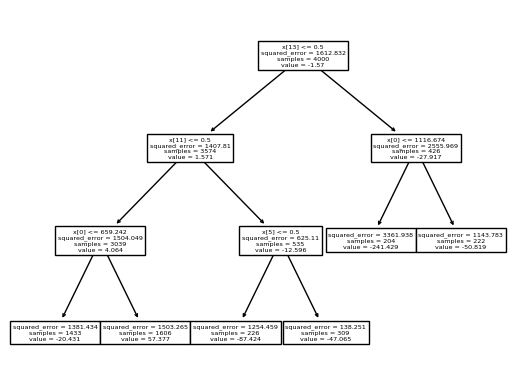

In [ ]:
plot_tree(vcboost_[('VC_model_coefficients', 0)][0][2])

In [ ]:
vcboost_[('VC_model_coefficients', 0)]

[[DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05),
  DecisionTreeRegressor(

In [ ]:
vcboost_[('VC', 0)]

8469.924921207254

In [ ]:
results_dict = benchmark_vc_booster(df_global, VCBooster(), x, y, features, T, 10, False)

Evaluation 1 / 10 of VCBooster
Evaluation 2 / 10 of VCBooster
Evaluation 3 / 10 of VCBooster
Evaluation 4 / 10 of VCBooster
Evaluation 5 / 10 of VCBooster
Evaluation 6 / 10 of VCBooster
Evaluation 7 / 10 of VCBooster
Evaluation 8 / 10 of VCBooster
Evaluation 9 / 10 of VCBooster
Evaluation 10 / 10 of VCBooster


In [ ]:
vcb = results_dict[('VC_booster', 0)] 

In [ ]:
df_encoded  = dummy_encode(df_global, features)

z           = [key for key, value in features.items() if value is not None]
z.extend([c for c in df_encoded.columns if 'dummy_' in c])

# df_subset   = df_encoded.sample(4000)        
X_subset    = df_subset[x].to_numpy()
# X_subset    = X_subset / 2
Y_subset    = df_subset[y].to_numpy()
Z_subset    = df_subset[z].to_numpy()
Z_subset    = Z_subset / 2

coeffs      = vcb.predict_coefficients_at_stage(X_subset, Z_subset)

In [ ]:
coeffs

array([[  97.52368621,   28.54241325,   -5.26286175, ...,    2.4049784 ,
         -28.8610152 ,  -99.19580771],
       [ 210.32586172,   41.47197576,  -56.27919461, ...,   39.79857705,
        -100.60122439, -147.22726976],
       [  97.52368621,   53.93074478,    0.34859359, ...,   33.94637634,
         -48.91548913, -126.9939456 ],
       ...,
       [ 202.81500837,   15.39783455,  -51.97890708, ...,   43.21732046,
        -106.31698327, -147.22726976],
       [  92.11578356,    9.40482046,  -20.24285671, ...,  -10.18788053,
         -46.1948838 ,  -63.19467037],
       [  91.62925426,    9.40482046,  -20.24285671, ...,  -10.18788053,
         -46.98153741,  -63.19467037]])

Ensuring that `comprehensive_benchmark` works

In [ ]:
with open(r"C:\Users\nial\Documents\GitHub\Master-Thesis\Comprehensive Benchmarks\tabulator_test\tabulator_test_tbl_avg.pkl", "rb") as f:
    tabulator_test = pkl.load(f)

In [ ]:
tabulator_test

,which,test_time_100,test_time_200,test_time_300,test_time_400,test_time_500
0,KCG,12338.675644,11247.062879,10382.496068,9646.009342,8468.223726
1,LL,12407.571860,18355.459231,11720.568605,7597.098938,6960.576645
2,MABS,12593.719155,13021.420061,10992.625014,10309.651468,9455.538700
3,TORRENT,8453.014910,8453.014910,8453.014910,8453.014910,8453.014910
4,full,6606.868750,6606.868750,6606.868750,6606.868750,6606.868750
5,mds,12633.893675,14400.925661,11045.251293,10984.243514,9800.125614
6,rb,12392.351040,13587.821554,10885.847524,10844.145344,8447.255362


In [ ]:
with open(r"C:\Users\nial\Documents\GitHub\Master-Thesis\Comprehensive Benchmarks\fourth_test\fourth_test.pkl", "rb") as f:
    fourth_test = pkl.load(f)

desc, repr_, results = fourth_test

In [ ]:
print(repr_)


        lazy_bandit(
        data, 
        x=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12'], 
        y='agbd', 
        features={'region_cla': None, 'elev_lowes': 3, 'selected_a': None},
        T=500, 
        batch_size=10, 
        test_freq=10, 
        test_times=range(100, 501, 100),
        model=MLP(
  (loss_fn): MSELoss()
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
  )
)
num_epochs = 5, 
 lr = 0.01, 
 with_scheduler = False)
        


### Testing `metadata_dist_selector`:

In [ ]:
df_bandit = bandit_global.dataset
mds = metadata_dist_selector(df_bandit, 2000)

In [ ]:
probs = mds.compute_probabilities(mds.dataset, mds.group_column)

819385    0.000176
709034    0.000075
116235    0.000030
109932    0.000036
452949    0.000020
            ...   
432398    0.000020
530544    0.000029
437428    0.000020
406922    0.000020
381754    0.000093
Name: ND_cluster, Length: 10000, dtype: float64

In [ ]:
'ch_std' in mds.dataset.columns

True

### Testing LL coreset selector

I pulled apart the `run_LL()` function in the `agent` and ran the code line by line to verify that outputs are as expected.

In [ ]:
selector  = LL_coreset_selector(n_predictors=bandit_global.model.n_predictors, 
                                        num_epochs=bandit_global.model.num_epochs, 
                                        print_freq=bandit_global.model.print_freq, 
                                        with_scheduler=bandit_global.model.with_scheduler, 
                                        loss_fn=bandit_global.model.loss_fn,
                                        FC_dim=32)

In [ ]:
# select `bandit_global.batch_size` random datapoints to begin
init_indices    = random.sample(bandit_global.hidden_indices, bandit_global.batch_size)

In [ ]:
len(init_indices)

10

In [ ]:
for idx in init_indices:
    bandit_global.train_indices.append(idx)
    bandit_global.hidden_indices.remove(idx)

len(bandit_global.train_indices)

10

In [ ]:
t               = bandit_global.batch_size
t

10

In [ ]:
X_hidden, _, X_train, y_train\
     = bandit_global.dataset_splitter(['hidden', 'train'])

In [ ]:
X_hidden.shape

(6648, 12)

In [ ]:
y_train

array([ 91.66455  ,   0.9703503,   0.       ,   5.6491523, 161.83595  ,
         4.615956 , 361.39294  ,   1.3916254,  45.118553 ,   2.1917922])

In [ ]:
selector    = selector.fit(X_train, y_train)

 Model fit 1. Epoch [1/5].
                      Epoch losses: combined = 19294.7754, MLP = 16630.3398, LL = 4.9958.
                      MLP lr: 0.01, LL lr: 0.001
 Model fit 1. Epoch [2/5].
                      Epoch losses: combined = 19274.8203, MLP = 16626.4199, LL = 4.9657.
                      MLP lr: 0.01, LL lr: 0.001
 Model fit 1. Epoch [3/5].
                      Epoch losses: combined = 19279.6035, MLP = 16622.1191, LL = 4.9828.
                      MLP lr: 0.01, LL lr: 0.001
 Model fit 1. Epoch [4/5].
                      Epoch losses: combined = 19278.7324, MLP = 16615.7617, LL = 4.9931.
                      MLP lr: 0.01, LL lr: 0.001
 Model fit 1. Epoch [5/5].
                      Epoch losses: combined = 19258.6914, MLP = 16606.8359, LL = 4.9722.
                      MLP lr: 0.01, LL lr: 0.001


In [ ]:
# estimate model loss on every hidden observation
losses      = selector.predict_losses(X_hidden)

In [ ]:
losses.size()

torch.Size([6648, 1])

In [ ]:
# retrieve indices of hidden obs in descending order of loss
top_K_idx   = selector.top_K_losses(losses, K=bandit_global.batch_size, indices=bandit_global.hidden_indices)

In [ ]:
top_K_idx

[655856, 142081, 654180, 654162, 80870, 655885, 88008, 362816, 887112, 654890]

In [ ]:
for idx in top_K_idx:
        bandit_global.train_indices.append(idx)
        bandit_global.hidden_indices.remove(idx)

        t           += bandit_global.batch_size

In [ ]:
bandit_global.train_indices

[480850,
 27346,
 10225,
 1006907,
 394784,
 811656,
 898226,
 990220,
 399820,
 238765,
 655856,
 142081,
 654180,
 654162,
 80870,
 655885,
 88008,
 362816,
 887112,
 654890]

In [ ]:
current_trainset = bandit_global.dataset.loc[bandit_global.train_indices]
current_trainset_array = current_trainset[x].to_numpy()
current_trainset_array

array([[0.3477136 , 0.32068166, 0.5259698 , 0.21360844, 0.59592444,
        0.90357035, 0.8883721 , 0.7836024 , 0.86600226, 0.8821958 ,
        0.5376468 , 0.2913299 ],
       [0.2648835 , 0.38419834, 0.2846811 , 0.23034021, 0.32107356,
        0.38712397, 0.34744188, 0.39232543, 0.35348842, 0.31066307,
        0.07386202, 0.05143274],
       [0.16134602, 0.04260261, 0.13806705, 0.09035136, 0.23906565,
        0.3533877 , 0.33093026, 0.40910038, 0.35991138, 0.19213018,
        0.2009734 , 0.15723734],
       [0.51941323, 0.32455456, 0.38724527, 0.39096484, 0.5646123 ,
        0.47624406, 0.44674426, 0.44894102, 0.482835  , 0.45931497,
        0.59719443, 0.50073475],
       [0.3477136 , 0.31525952, 0.39513478, 0.35917458, 0.46819085,
        0.31093618, 0.26860467, 0.31012788, 0.29435217, 0.26669905,
        0.5095906 , 0.37986776],
       [0.3019845 , 0.22773044, 0.3096647 , 0.13664249, 0.35636184,
        0.803486  , 0.8527908 , 0.79618365, 0.8786269 , 0.84527564,
        0.51932436,

In [ ]:
losses_new      = selector.predict_losses(current_trainset_array[10:])

In [ ]:
losses_new

tensor([[0.1013],
        [0.0976],
        [0.0974],
        [0.0967],
        [0.0963],
        [0.0957],
        [0.0957],
        [0.0955],
        [0.0943],
        [0.0942]])

In [ ]:
torch.topk(losses, k=10, dim=0)

torch.return_types.topk(
values=tensor([[0.1013],
        [0.0976],
        [0.0974],
        [0.0967],
        [0.0963],
        [0.0957],
        [0.0957],
        [0.0955],
        [0.0943],
        [0.0942]]),
indices=tensor([[1255],
        [2275],
        [5962],
        [6560],
        [2375],
        [3025],
        [5143],
        [3795],
        [6374],
        [5228]]))

### Testing LossNet

In [ ]:
loss_learner = LL_coreset_selector(n_predictors=n_predictors, num_epochs=10, lr_MLP=lr, lr_LL=1e-3, with_scheduler=with_scheduler, loss_fn=loss_fn)
X_h, y_h = bandit_global.dataset_splitter(['hidden'])
loss_learner.fit(X_h, y_h)

 Model fit 1. Epoch [1/10].
                      Epoch losses: combined = 12177.9131, MLP = 12160.972615943765, LL = 16.94046702249995.
                      MLP lr: 0.01, LL lr: 0.001
 Model fit 1. Epoch [2/10].
                      Epoch losses: combined = 7969.0157, MLP = 7950.6695913638705, LL = 18.346130901912474.
                      MLP lr: 0.01, LL lr: 0.001
 Model fit 1. Epoch [3/10].
                      Epoch losses: combined = 7975.7868, MLP = 7957.566934837485, LL = 18.21987155473457.
                      MLP lr: 0.01, LL lr: 0.001
 Model fit 1. Epoch [4/10].
                      Epoch losses: combined = 7899.7251, MLP = 7881.407657263414, LL = 18.31742932436601.
                      MLP lr: 0.01, LL lr: 0.001
 Model fit 1. Epoch [5/10].
                      Epoch losses: combined = 7912.2995, MLP = 7893.932198002653, LL = 18.367337440544706.
                      MLP lr: 0.01, LL lr: 0.001
 Model fit 1. Epoch [6/10].
                      Epoch losses: combined = 

In [ ]:
loss_learner = LL_coreset_selector(n_predictors=n_predictors, num_epochs=50, lr_MLP=lr, lr_LL=1e-3, with_scheduler=with_scheduler, loss_fn=loss_fn)
X_h, y_h = bandit_global.dataset_splitter(['hidden'])
loss_learner.ll_loss_weight = 8000 / 15

# try with a bigger model

new_architecture = nn.Sequential(   
        nn.Linear(in_features=12, out_features=32, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=64, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=64, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=32, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=1, bias=True),
        nn.Softplus()
    )

loss_learner.update_MLP_architecture(new_architecture)

c:\Users\nial\Documents\GitHub\Master-Thesis\custom_models.py:264: UserWarning: `forward()` method assumes that intermediate activation functions are all `ReLU()`
  warn("`forward()` method assumes that intermediate activation functions are all `ReLU()`")


Testing `KCG` and weight resets

In [ ]:
bandit_global.model.state_dict()['layers.0.weight'][0][0:10]

tensor([0.3915, 0.3894, 0.3119, 0.5489, 0.3592, 0.4165, 0.2593, 0.2836, 0.5886,
        0.3724])

In [ ]:
bandit_global.model

MLP(
  (loss_fn): MSELoss()
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
  )
)
num_epochs = 5, 
 lr = 0.01, 
 with_scheduler = True

In [ ]:
bandit_global.model.reset_model_new()
bandit_global.model.state_dict()['layers.0.weight'][0][0:10]

tensor([-0.2340, -0.0647, -0.1519,  0.1052, -0.2631,  0.2044, -0.0049, -0.0866,
         0.0468, -0.2740])

In [ ]:
bandit_global.model.reset_model()

Model built!
First 10 weights in layer 0: 
 tensor([-0.1816, -0.0490,  0.1381, -0.1636,  0.0245,  0.2085, -0.1098, -0.2420,
         0.1431,  0.2771])
MLP model reset


In [ ]:
bandit_global.model.reset_model()

Model built!
First 10 weights in layer 0: 
 tensor([-0.2336, -0.1190,  0.0996,  0.0246,  0.0169,  0.2034,  0.0891,  0.0802,
        -0.0472, -0.2634])
MLP model reset


In [ ]:
bandit_global.model.state_dict()['layers.0.weight'][0][0:10]

tensor([-0.1694,  0.3387, -0.1329, -0.0396,  0.1911,  0.3225,  0.2214, -0.0683,
         0.3490,  0.1813])

In [ ]:
bandit_global.model.reset_model()
bandit_global.model.state_dict()['layers.0.weight'][0][0:10]

Model built!
Model built!
State dict: 
 OrderedDict({'layers.0.weight': tensor([[-0.1694,  0.3387, -0.1329, -0.0396,  0.1911,  0.3225,  0.2214, -0.0683,
          0.3490,  0.1813, -0.1439, -0.2152],
        [ 0.0144,  0.0078,  0.0702, -0.2538,  0.2223,  0.3487,  0.1920,  0.3484,
          0.3098, -0.0525, -0.1222, -0.2395],
        [ 0.1554, -0.1340,  0.1013, -0.0856, -0.1781,  0.2349, -0.1343, -0.0740,
          0.2831, -0.1772,  0.0050, -0.1231],
        [-0.0169,  0.0230, -0.2241, -0.0931,  0.2382,  0.2305,  0.3357,  0.0284,
          0.2857,  0.0595, -0.0215, -0.0525],
        [-0.1503, -0.2083, -0.1425,  0.0155,  0.1904,  0.0861,  0.3346,  0.3923,
          0.2359, -0.0707, -0.2113,  0.1777],
        [-0.2017, -0.2524,  0.2246, -0.1641, -0.2704, -0.1326, -0.0158,  0.2185,
          0.2690,  0.0115, -0.1932, -0.0689],
        [-0.1596, -0.2258,  0.1897,  0.1718, -0.2041,  0.2736,  0.0296,  0.1252,
         -0.0043,  0.3158,  0.0453, -0.0221],
        [-0.0258,  0.3134,  0.1406,  0.

tensor([-0.1694,  0.3387, -0.1329, -0.0396,  0.1911,  0.3225,  0.2214, -0.0683,
         0.3490,  0.1813])

In [ ]:
random.seed(3)

In [ ]:
bandit_global.model.reset_model

<bound method MLP.reset_model of MLP(
  (loss_fn): MSELoss()
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Softplus(beta=1.0, threshold=20.0)
  )
)
num_epochs = 5, 
 lr = 0.01, 
 with_scheduler = True>

In [ ]:
bandit_global.model.reset_model()
bandit_global.model.state_dict()['layers.0.weight'][0][0:10]

Model built!
Model built!
State dict: 
 OrderedDict({'layers.0.weight': tensor([[-0.1694,  0.3387, -0.1329, -0.0396,  0.1911,  0.3225,  0.2214, -0.0683,
          0.3490,  0.1813, -0.1439, -0.2152],
        [ 0.0144,  0.0078,  0.0702, -0.2538,  0.2223,  0.3487,  0.1920,  0.3484,
          0.3098, -0.0525, -0.1222, -0.2395],
        [ 0.1554, -0.1340,  0.1013, -0.0856, -0.1781,  0.2349, -0.1343, -0.0740,
          0.2831, -0.1772,  0.0050, -0.1231],
        [-0.0169,  0.0230, -0.2241, -0.0931,  0.2382,  0.2305,  0.3357,  0.0284,
          0.2857,  0.0595, -0.0215, -0.0525],
        [-0.1503, -0.2083, -0.1425,  0.0155,  0.1904,  0.0861,  0.3346,  0.3923,
          0.2359, -0.0707, -0.2113,  0.1777],
        [-0.2017, -0.2524,  0.2246, -0.1641, -0.2704, -0.1326, -0.0158,  0.2185,
          0.2690,  0.0115, -0.1932, -0.0689],
        [-0.1596, -0.2258,  0.1897,  0.1718, -0.2041,  0.2736,  0.0296,  0.1252,
         -0.0043,  0.3158,  0.0453, -0.0221],
        [-0.0258,  0.3134,  0.1406,  0.

tensor([-0.1694,  0.3387, -0.1329, -0.0396,  0.1911,  0.3225,  0.2214, -0.0683,
         0.3490,  0.1813])

In [4]:
bandit_global.sampled_C

[38, 14, 6, 10, 36, 19, 41, 12, 19, 19, 3, 2, 28, 1, 22, 5, 36, 7, 9, 37]

In [ ]:
saved_state_dict = torch.load(r'C:\Users\nial\Documents\GitHub\Master-Thesis\State dict\MLP_state_dict.pt')

In [ ]:
saved_state_dict

OrderedDict([('layers.0.weight',
              tensor([[-0.2576,  0.2843, -0.1761, -0.0325,  0.1535,  0.2192,  0.1014, -0.1873,
                        0.2248,  0.0631, -0.1940, -0.2271],
                      [-0.1001, -0.0732,  0.0008, -0.2712,  0.1595,  0.2202,  0.0467,  0.2043,
                        0.1604, -0.1961, -0.1975, -0.2760],
                      [ 0.1554, -0.1340,  0.1013, -0.0856, -0.1781,  0.2349, -0.1343, -0.0740,
                        0.2831, -0.1772,  0.0050, -0.1231],
                      [-0.0406,  0.0310, -0.2064, -0.0258,  0.2612,  0.1920,  0.2813, -0.0244,
                        0.2273,  0.0067, -0.0102, -0.0046],
                      [-0.2266, -0.2496, -0.1732,  0.0368,  0.1638, -0.0081,  0.2236,  0.2828,
                        0.1205, -0.1806, -0.2514,  0.1783],
                      [-0.2017, -0.2524,  0.2246, -0.1641, -0.2704, -0.1326, -0.0158,  0.2185,
                        0.2690,  0.0115, -0.1932, -0.0689],
                      [-0.2017, -0.23

Testing K center greedy implementation

In [ ]:
dataset             = df_global_subset[df_global_subset['new_colour'] == 'train']
x                   = x
budget              = T
distance_metric     = euclidean

greedy_picker       = k_center_greedy(dataset, x, budget, distance_metric)

In [ ]:
# T=4000, full dataset; test run time
# ~ 40s per 10 centers => ~ 30 min for 4000 dp. Too slow...
# let's save 10 coresets overnight
greedy_picker.run()

10 centers added to coreset
Deque size: 10


KeyboardInterrupt: 

Extensive testing

Benchmarking run 1 for model full
MLP model reset
Batch 0. Epoch [1/5], Training loss: 6881.0808, lr: 0.1
Batch 0. Epoch [2/5], Training loss: 6392.8140, lr: 0.1
Batch 0. Epoch [3/5], Training loss: 10685.1280, lr: 0.1
Batch 0. Epoch [4/5], Training loss: 22936.9383, lr: 0.1
Batch 0. Epoch [5/5], Training loss: 22936.9383, lr: 0.1
Benchmarking run 1 for model rb
MLP model reset
Batch 0. Epoch [1/5], Training loss: 28146.9822, lr: 0.1
Batch 0. Epoch [2/5], Training loss: 27191.2222, lr: 0.1
Batch 0. Epoch [3/5], Training loss: 22028.3945, lr: 0.1
Batch 0. Epoch [4/5], Training loss: 21531.0188, lr: 0.1
Batch 0. Epoch [5/5], Training loss: 19278.0623, lr: 0.1
Batch 10. Epoch [1/5], Training loss: 22566.9639, lr: 0.05
Batch 10. Epoch [2/5], Training loss: 22522.2776, lr: 0.05
Batch 10. Epoch [3/5], Training loss: 19132.5426, lr: 0.05
Batch 10. Epoch [4/5], Training loss: 24181.5603, lr: 0.05
Batch 10. Epoch [5/5], Training loss: 20921.1351, lr: 0.05
Batch 20. Epoch [1/5], Training loss: 1

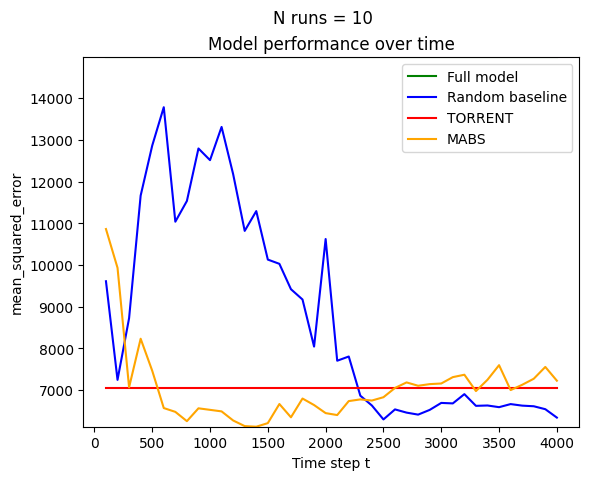

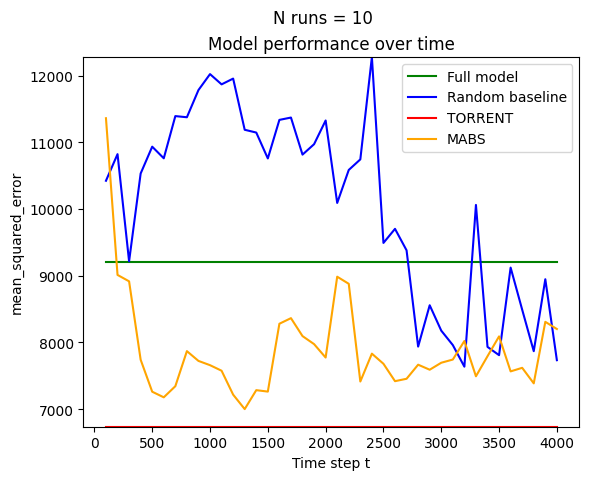

In [ ]:
benchmark_bandit(bandit_global, n_runs=10, description='Full dataset, simpler model.')

print("Benchmarking simple model complete!")

bandit_global.model.layers  = nn.Sequential(
    nn.Linear(in_features=12, out_features=32, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=64, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=64, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=1, bias=True),
    nn.Softplus()
)

bandit_global.model.save_initial_state()
bandit_global.reset()

benchmark_bandit(bandit_global, n_runs=10, description='Full dataset, sophisticated model.')

In [ ]:
df_global['selected_a'].unique()

['2.0', '1.0', '5.0']
Categories (3, object): ['1.0', '2.0', '5.0']

In [ ]:
specs_simplemod     = load_specs('20', '08', '2024', '21', '43', '29')
specs_simplemod['Average test scores']

specs_sophmod       = load_specs('20', '08', '2024', '23', '20', '26')
specs_sophmod['Average test scores']

{'Full model': array([9202.60754477, 9202.60754477, 9202.60754477, 9202.60754477,
        9202.60754477, 9202.60754477, 9202.60754477, 9202.60754477,
        9202.60754477, 9202.60754477, 9202.60754477, 9202.60754477,
        9202.60754477, 9202.60754477, 9202.60754477, 9202.60754477,
        9202.60754477, 9202.60754477, 9202.60754477, 9202.60754477,
        9202.60754477, 9202.60754477, 9202.60754477, 9202.60754477,
        9202.60754477, 9202.60754477, 9202.60754477, 9202.60754477,
        9202.60754477, 9202.60754477, 9202.60754477, 9202.60754477,
        9202.60754477, 9202.60754477, 9202.60754477, 9202.60754477,
        9202.60754477, 9202.60754477, 9202.60754477, 9202.60754477]),
 'Random baseline': array([10424.84214243, 10823.8878558 ,  9217.21517606, 10533.49211933,
        10935.86944152, 10761.60592486, 11394.39059811, 11377.11048641,
        11784.88073515, 12023.94748901, 11870.22185372, 11956.79437755,
        11189.33421766, 11147.5982039 , 10759.54814244, 11337.5488671

Full training data

In [ ]:
test_scores = assess_stability(df_global_subset, x, y, colour_col='new_colour', n_seed=10,
                 n_predictors=n_predictors, num_epochs=num_epochs, lr=lr, with_scheduler=with_scheduler, loss_fn=loss_fn)

Fitting model 1
Batch 0. Epoch [1/5], Training loss: 5904.3483, lr: 0.01
Batch 0. Epoch [2/5], Training loss: 5771.1019, lr: 0.01
Batch 0. Epoch [3/5], Training loss: 5757.6344, lr: 0.01
Batch 0. Epoch [4/5], Training loss: 5764.5587, lr: 0.01
Batch 0. Epoch [5/5], Training loss: 5774.3559, lr: 0.01
Test score 0: 6208.08984375
Fitting model 2


c:\Users\nial\Documents\GitHub\Master-Thesis\custom_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(array, dtype=torch.float32)


Batch 0. Epoch [1/5], Training loss: 5937.3906, lr: 0.01
Batch 0. Epoch [2/5], Training loss: 5811.5276, lr: 0.01
Batch 0. Epoch [3/5], Training loss: 5754.4871, lr: 0.01
Batch 0. Epoch [4/5], Training loss: 5752.5283, lr: 0.01
Batch 0. Epoch [5/5], Training loss: 5811.0362, lr: 0.01
Test score 1: 6354.36474609375
Fitting model 3
Batch 0. Epoch [1/5], Training loss: 6077.4485, lr: 0.01
Batch 0. Epoch [2/5], Training loss: 5770.5691, lr: 0.01
Batch 0. Epoch [3/5], Training loss: 5778.4894, lr: 0.01
Batch 0. Epoch [4/5], Training loss: 5705.4502, lr: 0.01
Batch 0. Epoch [5/5], Training loss: 5764.9855, lr: 0.01
Test score 2: 6585.8564453125
Fitting model 4
Batch 0. Epoch [1/5], Training loss: 5945.5319, lr: 0.01
Batch 0. Epoch [2/5], Training loss: 5788.2263, lr: 0.01
Batch 0. Epoch [3/5], Training loss: 5740.7595, lr: 0.01
Batch 0. Epoch [4/5], Training loss: 5758.4872, lr: 0.01
Batch 0. Epoch [5/5], Training loss: 5706.6815, lr: 0.01
Test score 3: 6340.41162109375
Fitting model 5
Batch

### Analysing latest TTV split: 65-15-20

In [14]:
with open(r"C:\Users\nial\OneDrive\ETH Zürich\Master Thesis\colouring-Tr=0.65-Te=0.2-V=0.15.pkl", "rb") as colouring_file:

    colouring = pkl.load(colouring_file)

colouring

{'36MUS': 'val',
 '10TEM': 'val',
 '36MXU': 'val',
 '34SEH': 'val',
 '48SYG': 'test',
 '36LYR': 'test',
 '58GFQ': 'test',
 '60HTE': 'test',
 '36MUA': 'test',
 '37MDN': 'test',
 '37MEQ': 'test',
 '36LXQ': 'test',
 '49SCC': 'test',
 '20KPU': 'test',
 '10TEL': 'train',
 '21KWQ': 'train',
 '21JWL': 'train',
 '49SCV': 'train',
 '36MYU': 'train',
 '36MWU': 'train',
 '49SDV': 'train',
 '10TFM': 'train',
 '59GMJ': 'train',
 '21NZD': 'train',
 '33UVQ': 'train',
 '49SDT': 'train',
 '37MBP': 'train',
 '37MCR': 'train',
 '37MCS': 'train',
 '36LVQ': 'train',
 '30NXM': 'train',
 '37LEH': 'train',
 '34TCK': 'train'}

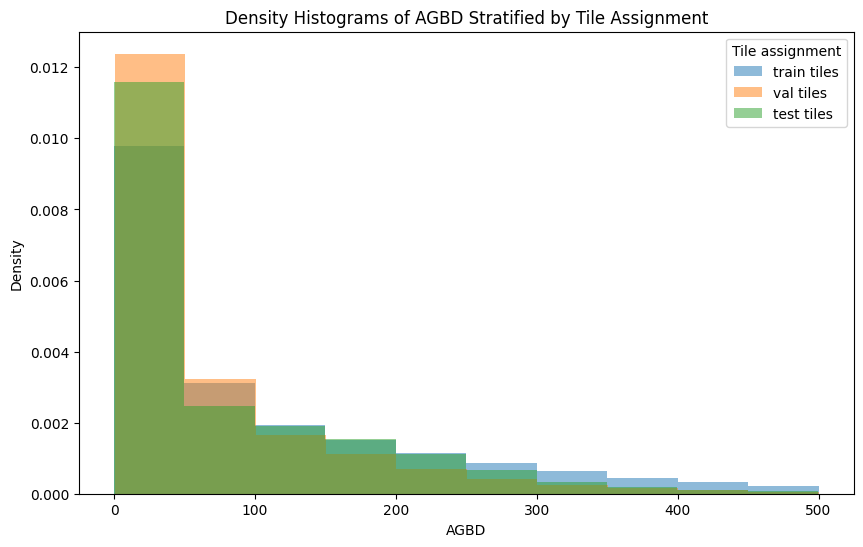

In [15]:
from custom_ttv_split import plot_agbd_distributions
plot_agbd_distributions(colouring, df_global)

Map new colours to data

In [12]:
df_global                   = load_data()
df_global['new_colour']     = df_global['tile_name'].map(colouring)
df_global.to_csv(r"C:\Users\nial\polybox - Nial Perry (nperry@student.ethz.ch)@polybox.ethz.ch\Nial MT\df_global.csv", index=False)

### Comparing runs

In [4]:
specs_full      = load_specs('15', '08', '2024', '10', '12', '00')
specs_porous    = load_specs('14', '08', '2024', '10', '39', '11') 
specs_vanilla   = load_specs('28', '07', '2024', '17', '45', '16')

In [ ]:
{key: round(value, 2) for key, value in specs_full['Terminal test scores'].items()}

{'Full model': 6922.95,
 'Random baseline': 7096.39,
 'TORRENT': 7216.52,
 'MABS': 6864.91}

In [ ]:
{key: round(value, 2) for key, value in specs_porous['Terminal test scores'].items()}

{'Full model': 8201.71,
 'Random baseline': 7550.5,
 'TORRENT': 7186.26,
 'MABS': 6987.33}

In [ ]:
{key: round(value, 2) for key, value in specs_vanilla['Terminal test scores'].items()}

{'Full model': 7652.84,
 'Random baseline': 7279.28,
 'TORRENT': 7378.79,
 'MABS': 6725.84}

### Investigating the Elbow at t=600

In [ ]:
ts_dict = dict()
for i in range(10):

    bandit_global.reset()
    bandit_global.run_random_baseline()

    ts_i        = bandit_global.test_scores[:]
    ts_dict[i]  = ts_i 

MLP model reset
Batch 0. Epoch [1/5], Training loss: 14801.4486, lr: 0.1
Batch 0. Epoch [2/5], Training loss: 12357.4255, lr: 0.1
Batch 0. Epoch [3/5], Training loss: 11511.2076, lr: 0.1
Batch 0. Epoch [4/5], Training loss: 11521.1407, lr: 0.1
Batch 0. Epoch [5/5], Training loss: 10581.2284, lr: 0.1
Batch 10. Epoch [1/5], Training loss: 13950.8805, lr: 0.1
Batch 10. Epoch [2/5], Training loss: 8732.9482, lr: 0.1
Batch 10. Epoch [3/5], Training loss: 8236.2884, lr: 0.1
Batch 10. Epoch [4/5], Training loss: 8119.2429, lr: 0.1
Batch 10. Epoch [5/5], Training loss: 8093.2101, lr: 0.1
Batch 20. Epoch [1/5], Training loss: 11632.7580, lr: 0.1
Batch 20. Epoch [2/5], Training loss: 8164.5375, lr: 0.1
Batch 20. Epoch [3/5], Training loss: 8033.3688, lr: 0.1
Batch 20. Epoch [4/5], Training loss: 8007.3228, lr: 0.1
Batch 20. Epoch [5/5], Training loss: 7961.6675, lr: 0.1
Batch 30. Epoch [1/5], Training loss: 10831.3079, lr: 0.1
Batch 30. Epoch [2/5], Training loss: 8204.3191, lr: 0.1
Batch 30. Ep

Text(0.5, 1.0, 'Average in --, individual in -')

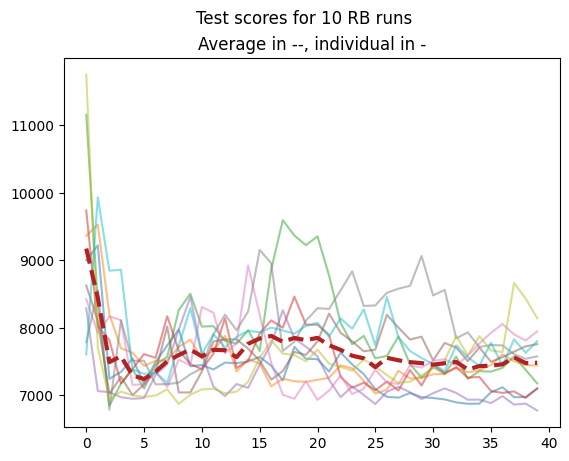

In [ ]:
ts_avg = [0] * 40

for i, ts_i in ts_dict.items():

    plt.plot(ts_i, alpha=0.5)
    ts_avg = [sum(x) for x in zip(ts_avg, ts_i)]

ts_avg      = [x/10 for x in ts_avg]
plt.plot(ts_avg, color="firebrick", ls='--', linewidth=3)
plt.suptitle("Test scores for 10 RB runs")
plt.title("Average in --, individual in -")

### Analysing feature search

The random baseline scores exhibit a higher variance than the MABS scores, suggesting that feature choice makes a difference beyond random fluctuations.

The following runs look particularly promising in the plots:

* 17.05.42
* 17.45.16
* 18.25.00
* 21.12.26

We will load all the specs and compare them, paying particular attention to these four runs. Is there a choice / combination of features that makes these particularly good?

In [ ]:
directory       = r"C:\Users\nial\Documents\GitHub\Master-Thesis\Results"
timestamps      = [ts for ts in [timestamp for _, timestamp, _ in os.walk(directory)][0] if ('28-07' in ts or '29-07' in ts)]

specs_dict      = dict()

for ts in timestamps:

    specs_path          = os.path.join(directory, ts, 'Specs.pkl')
    
    with open(specs_path, 'rb') as f:
        specs_dict[ts]  = pkl.load(f)

df_results          = pd.DataFrame(columns=['Timestamp', 'Description', 'Terminal test score (full model)'
                                        , 'Terminal test score (RB)', 'Terminal test score (TORRENT)'
                                        , 'Terminal test score (MABS)'], index=range(len(specs_dict)))

for i, (key, value) in enumerate(specs_dict.items()):
    
    df_results.loc[df_results.index[i], 'Timestamp']\
                                        = key
    df_results.loc[df_results.index[i], 'Description']\
                                        = value['Description']

    df_results.loc[df_results.index[i], 'Terminal test score (full model)']\
                                        = value['Terminal test scores']['Full model']
    df_results.loc[df_results.index[i], 'Terminal test score (RB)']\
                                        = value['Terminal test scores']['Random baseline']
    
    df_results.loc[df_results.index[i], 'Terminal test score (TORRENT)']\
                                        = value['Terminal test scores']['TORRENT']
    df_results.loc[df_results.index[i], 'Terminal test score (MABS)']\
                                        = value['Terminal test scores']['MABS']
    
df_results.sort_values(by='Terminal test score (MABS)', ascending=True, inplace=True)
df_results.reset_index(inplace=True, drop=True)
df_results.to_csv(os.path.join(directory, "df_results.csv"))

In [ ]:
df_results.head()

,Timestamp,Description,Terminal test score (full model),Terminal test score (RB),Terminal test score (TORRENT),Terminal test score (MABS)
0,"28-07-2024, 17.45.16","region_cla, elev_lowes, selected_a",7652.837191,7279.277778,7378.791836,6725.836797
1,"28-07-2024, 21.12.26","sensitivit, region_cla, elev_lowes",7652.837191,7244.765887,7378.791836,6764.399249
2,"28-07-2024, 17.05.42","sensitivit, region_cla, selected_a",7652.837191,7322.416036,7378.791836,6817.425667
3,"29-07-2024, 01.06.47","gedi_num_days, elev_lowes, selected_a",7652.837191,7254.623938,7378.791836,6893.657873
4,"28-07-2024, 18.25.00","pft_class, region_cla, elev_lowes",7652.837191,7333.860115,7378.791836,6899.317601


In [ ]:
for feature in ['pft_class', 'gedi_num_days', 'sensitivit', 'selected_a', 'region_cla', 'elev_lowes']:

    avg_rank        = np.mean(df_results[df_results['Description'].str.contains(feature)].index)
    print(feature + ", average rank:  "+ str(avg_rank))

pft_class, average rank:  13.0
gedi_num_days, average rank:  11.7
sensitivit, average rank:  9.8
selected_a, average rank:  7.9
region_cla, average rank:  8.3
elev_lowes, average rank:  6.3


In [ ]:
np.std(df_results['Terminal test score (RB)']), np.std(df_results['Terminal test score (MABS)'])

(46.935020267857524, 268.89252738223524)

### Testing the `reset_model_parameters()` method of the `MLP()`

In [ ]:
mlp_test = MLP(lr=0.01)

In [ ]:
mlp_test.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[-1.7725e-01, -8.0801e-02, -1.2655e-01, -1.6921e-01,  1.6047e-01,
                       -2.4082e-01,  2.2508e-01,  1.9827e-02, -2.4130e-02,  2.2784e-01,
                       -1.0929e-01,  1.9830e-01],
                      [ 1.7183e-01,  7.4255e-02,  2.5018e-01,  9.7333e-02, -9.1000e-02,
                        1.3681e-02,  8.9149e-02, -1.7333e-01, -9.8761e-02, -1.3256e-01,
                       -1.0056e-01,  2.7845e-02],
                      [ 1.1330e-01,  2.3857e-01, -9.8897e-02, -1.5064e-02, -3.5706e-03,
                       -2.0592e-01, -5.0537e-02, -1.5435e-01,  2.4894e-01, -2.2260e-02,
                        2.7992e-01,  9.4989e-02],
                      [ 1.5034e-01,  2.6120e-01, -2.0115e-01, -9.1754e-03, -6.7325e-02,
                       -8.6602e-02,  2.6507e-01,  1.5840e-01, -2.8341e-02, -2.8405e-01,
                       -1.2883e-02,  1.0106e-01],
                      [ 1.2358e-01, -4.7308e-02, -2.2716e-01, -

In [ ]:
X_train = df_global_subset[df_global_subset['colour'] == 'train'][x].to_numpy()
y_train = df_global_subset[df_global_subset['colour'] == 'train'][y].to_numpy()

mlp_test.fit(X_train, y_train)

Batch 0. Epoch [1/5], Training loss: 8397.7310, lr: 0.01
Batch 0. Epoch [2/5], Training loss: 7521.1753, lr: 0.01
Batch 0. Epoch [3/5], Training loss: 7383.3465, lr: 0.01
Batch 0. Epoch [4/5], Training loss: 7221.3466, lr: 0.01
Batch 0. Epoch [5/5], Training loss: 7080.0426, lr: 0.01


In [ ]:
mlp_test.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[-2.2852e-01, -1.3206e-01, -1.7782e-01, -2.2047e-01,  1.0921e-01,
                       -2.9208e-01,  1.7381e-01, -3.1436e-02, -7.5393e-02,  1.7658e-01,
                       -1.6056e-01,  1.4704e-01],
                      [ 1.9078e+00,  3.5054e-01, -1.4299e-02,  1.6420e+00, -1.3828e+00,
                        9.7621e-01,  8.6440e-01, -4.7966e-01, -4.4827e-01, -1.5285e+00,
                       -2.0869e+00, -9.1985e-01],
                      [ 1.7433e-01,  7.6337e-01,  7.3551e-01, -1.8736e+00, -2.9128e+00,
                       -2.0650e-01,  2.3673e-01, -7.5236e-01, -3.8648e-02, -6.9460e-01,
                        2.0633e+00, -5.2639e-01],
                      [-2.9483e-01, -8.3081e-01, -1.4584e+00,  1.7470e+00, -7.8197e-01,
                        8.2165e-01,  9.6394e-01,  3.0324e-01, -3.7562e-02, -1.5138e+00,
                       -1.0090e+00, -7.7624e-02],
                      [ 5.5912e-02, -1.1586e-01, -2.9150e-01, -

In [ ]:
mlp_test.reset_model_parameters()

In [ ]:
mlp_test.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[-1.7725e-01, -8.0801e-02, -1.2655e-01, -1.6921e-01,  1.6047e-01,
                       -2.4082e-01,  2.2508e-01,  1.9827e-02, -2.4130e-02,  2.2784e-01,
                       -1.0929e-01,  1.9830e-01],
                      [ 1.7183e-01,  7.4255e-02,  2.5018e-01,  9.7333e-02, -9.1000e-02,
                        1.3681e-02,  8.9149e-02, -1.7333e-01, -9.8761e-02, -1.3256e-01,
                       -1.0056e-01,  2.7845e-02],
                      [ 1.1330e-01,  2.3857e-01, -9.8897e-02, -1.5064e-02, -3.5706e-03,
                       -2.0592e-01, -5.0537e-02, -1.5435e-01,  2.4894e-01, -2.2260e-02,
                        2.7992e-01,  9.4989e-02],
                      [ 1.5034e-01,  2.6120e-01, -2.0115e-01, -9.1754e-03, -6.7325e-02,
                       -8.6602e-02,  2.6507e-01,  1.5840e-01, -2.8341e-02, -2.8405e-01,
                       -1.2883e-02,  1.0106e-01],
                      [ 1.2358e-01, -4.7308e-02, -2.2716e-01, -

Now we try an `ND_bandit()`

Set column types and load data

In [ ]:
column_types = {
    "B01": "float64",
    "B02": "float64",
    "B03": "float64",
    "B04": "float64",
    "B05": "float64",
    "B06": "float64",
    "B07": "float64",
    "B08": "float64",
    "B8A": "float64",
    "B09": "float64",
    "B11": "float64",
    "B12": "float64",
    "lat_cos": "float64",
    "lat_sin": "float64",
    "lon_cos": "float64",
    "lon_sin": "float64",
    "gedi_num_days": "float64",
    "gedi_doy_cos": "float64",
    "gedi_doy_sin": "float64",
    "agbd_se": "float64",
    "elev_lowes": "float64",
    "pft_class": "category",
    "region_cla": "category",
    "rh98": "float64",
    "selected_a": "category",
    "sensitivit": "float64",
    "solar_elev": "float64",
    "urban_prop": "float64",
    "alos_hh": "float64",
    "alos_hv": "float64",
    "ch": "float64",
    "ch_std": "float64",
    "lc_cos": "float64",
    "lc_sin": "float64",
    "lc_prob": "float64",
    "dem": "float64",
    "agbd": "float64",
    "identity": "category"
}

df_satellite_band = pd.read_csv("df_satellite_band.csv", dtype=column_types)
# df_satellite_band = df_satellite_band.astype(column_types)

FileNotFoundError: [Errno 2] No such file or directory: 'df_satellite_band.csv'

In [4]:
frac_train              = 0.5
frac_test               = 0.48
frac_val                = 0.02

x                       = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"]
y                       = 'agbd'
features                = {'pft_class':None, 'sensitivit':3, 'alos_hh':3}
T                       = 1000
batch_size              = 1
test_freq               = 50

lr                      = 0.01
num_epochs              = 10

bandit_satellite        = ND_bandit(df_satellite_band, x=x, y=y, features=features
                                    , frac_train=frac_train, frac_test=frac_test, frac_val=frac_val
                                    , T=T, batch_size=batch_size, test_freq=test_freq)

bandit_satellite.score  = mean_squared_error
bandit_satellite.model  = MLP(n_predictors=bandit_satellite.predictor_count, lr=lr, num_epochs=num_epochs)

In [8]:
bandit_satellite.train_indices      = bandit_satellite.hidden_indices[:]

In [9]:
X_train         = bandit_satellite.dataset[bandit_satellite.dataset.index.isin(bandit_satellite.train_indices)][bandit_satellite.x].to_numpy()
y_train         = bandit_satellite.dataset[bandit_satellite.dataset.index.isin(bandit_satellite.train_indices)][bandit_satellite.y].to_numpy()
X_test          = bandit_satellite.dataset[bandit_satellite.dataset.index.isin(bandit_satellite.test_indices)][bandit_satellite.x].to_numpy()
y_test          = bandit_satellite.dataset[bandit_satellite.dataset.index.isin(bandit_satellite.test_indices)][bandit_satellite.y].to_numpy()

Benchmarking run 1 for model full
Timestep 0. Epoch [1/5], Training loss: 1253.1975
Timestep 0. Epoch [2/5], Training loss: 1133.3530
Timestep 0. Epoch [3/5], Training loss: 1099.4086
Timestep 0. Epoch [4/5], Training loss: 1079.5215
Timestep 0. Epoch [5/5], Training loss: 1068.0936
Benchmarking run 1 for model rb
Timestep 0. Epoch [1/5], Training loss: 421.0737
Timestep 0. Epoch [2/5], Training loss: 389.3989
Timestep 0. Epoch [3/5], Training loss: 359.1838
Timestep 0. Epoch [4/5], Training loss: 331.0100
Timestep 0. Epoch [5/5], Training loss: 304.5076
Timestep 100. Epoch [1/5], Training loss: 1764.5145
Timestep 100. Epoch [2/5], Training loss: 1757.0933
Timestep 100. Epoch [3/5], Training loss: 1753.0432
Timestep 100. Epoch [4/5], Training loss: 1749.3774
Timestep 100. Epoch [5/5], Training loss: 1746.0242
Timestep 200. Epoch [1/5], Training loss: 1612.6649
Timestep 200. Epoch [2/5], Training loss: 1606.6049
Timestep 200. Epoch [3/5], Training loss: 1605.0086
Timestep 200. Epoch [4/

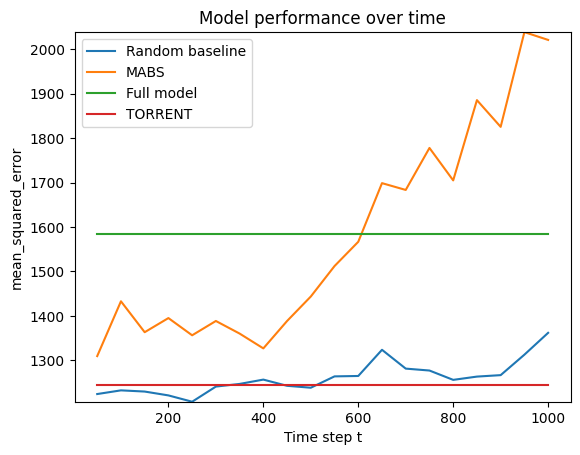

In [5]:
bandit_satellite.benchmark_MABS()

In [8]:
bandit_satellite.model.lr

0.001

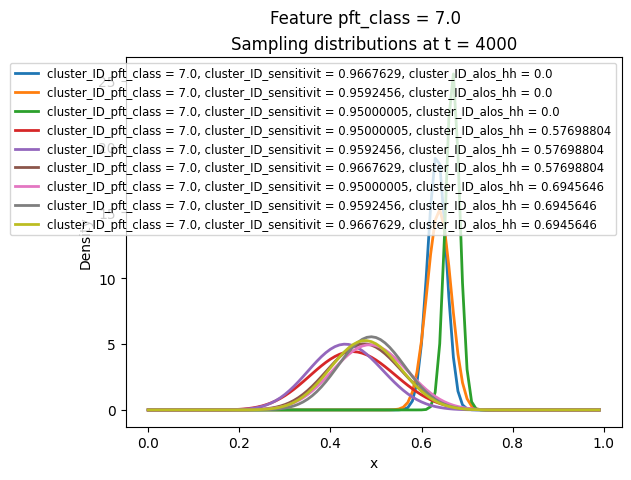

In [15]:
bandit_satellite.plot_beta_dist('pft_class', '7.0')

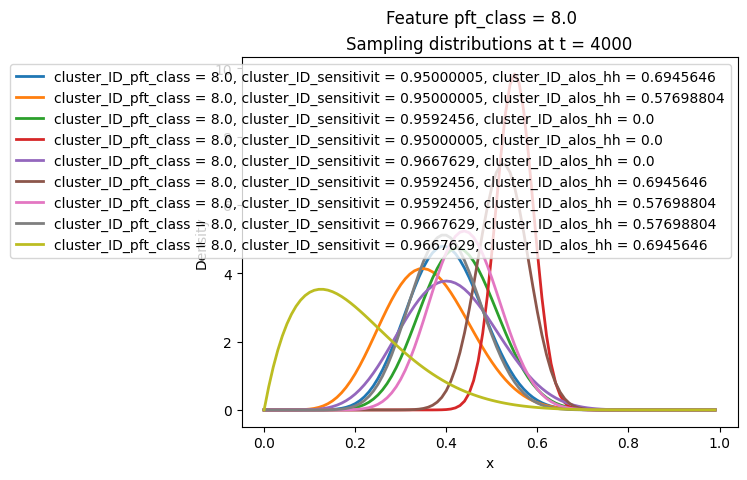

In [40]:
bandit_satellite.plot_beta_dist('pft_class', '8.0')

With MSE, all the error scores are very high! MSE = 3600 for the full model corresponds to errors around 63.

In [38]:
df_test         = df_satellite_band[df_satellite_band['identity'] == 'test']
df_train        = df_satellite_band[df_satellite_band['identity'] == 'train']
df_val          = df_satellite_band[df_satellite_band['identity'] == 'val']

mean_str        = "Mean of agbd in {} data is {}"

print(mean_str.format("train", round(np.mean(df_train['agbd']), 2)))
print(mean_str.format("test", round(np.mean(df_test['agbd']),2)))
print(mean_str.format("validation", round(np.mean(df_val['agbd']),2)))

Mean of agbd in train data is 25.47
Mean of agbd in test data is 44.89
Mean of agbd in validation data is 33.38


In [41]:
hidden_indices          = df_satellite_band[df_satellite_band['identity'] == 'train'].index.tolist()
val_indices             = df_satellite_band[df_satellite_band['identity'] == 'val'].index.tolist()
test_indices            = df_satellite_band[df_satellite_band['identity'] == 'test'].index.tolist()

x                       = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"]
y                       = 'agbd'
features                = {'pft_class':None, 'sensitivit':3, 'alos_hh':3}
T                       = 4000
batch_size              = 1
test_freq               = 50

bandit_satellite        = ND_bandit(df_satellite_band, x=x, y=y, features=features
                                      , hidden_indices=hidden_indices, test_indices=test_indices, val_indices=val_indices
                                      , T=T, batch_size=batch_size, test_freq=test_freq)

bandit_satellite.score  = log_ratio

In [8]:
df_satellite_band.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'lat_cos', 'lat_sin', 'lon_cos', 'lon_sin',
       'gedi_num_days', 'gedi_doy_cos', 'gedi_doy_sin', 'agbd_se',
       'elev_lowes', 'pft_class', 'region_cla', 'rh98', 'selected_a',
       'sensitivit', 'solar_elev', 'urban_prop', 'alos_hh', 'alos_hv', 'ch',
       'ch_std', 'lc_cos', 'lc_sin', 'lc_prob', 'dem', 'agbd', 'identity'],
      dtype='object')

### 19/07 New Dataset

In [6]:
df_global = load_data()

with open(r"C:\Users\nial\OneDrive\ETH Zürich\Master Thesis\colouring.pkl", "rb") as colouring_file:

    colouring = pkl.load(colouring_file)

In [1]:
def decode_lat_lon(lat_cos, lat_sin, lon_cos, lon_sin):
    """
    Decode the sine/cosine values back into latitude and longitude.

    Args:
    - lat_cos (float): the cosine value of the latitude in [0, 1]
    - lat_sin (float): the sine value of the latitude in [0, 1]
    - lon_cos (float): the cosine value of the longitude in [0, 1]
    - lon_sin (float): the sine value of the longitude in [0, 1]

    Returns:
    - (lat, lon) (tuple): the decoded latitude and longitude
    """

    # Revert the values from [0,1] range back to [-1,1]
    lat_cos, lat_sin = lat_cos * 2 - 1, lat_sin * 2 - 1
    lon_cos, lon_sin = lon_cos * 2 - 1, lon_sin * 2 - 1

    # Calculate the latitude and longitude in radians
    lat_rad = np.arctan2(lat_sin, lat_cos)
    lon_rad = np.arctan2(lon_sin, lon_cos)

    # Convert from radians to degrees
    lat = lat_rad * 90 / np.pi
    lon = lon_rad * 180 / np.pi

    return lat, lon

In [11]:
df_global[['lat', 'lon']] = df_global.apply(lambda row: pd.Series(decode_lat_lon(row['lat_cos'], row['lat_sin'], row['lon_cos'], row['lon_sin'])), axis=1)

In [ ]:
# folium plot TTV split
subset = df_global.sample(n=1000, axis=0)

center_lat  = subset['lat'].mean()
center_lon  = subset['lon'].mean()
m           = folium.Map(location=[center_lat, center_lon], zoom_start=10)

colour_map = {
         'train': 'orange'
        ,'test' : 'blue'
        ,'val'  : 'green'
}

for _, row in subset.iterrows():
        
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            color=colour_map.get(row['colour'], 'gray'),
            fill=True
        ).add_to(m)

display(m)

### Custom TTV split

TTV split initialised
Loaded data!
Train proportion: 0.65
Test proportion: 0.2
Validation proportion: 0.15
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.6602725362775282, test = 0.1995762894221026, val = 0.1401511743003689
Coloured tiles


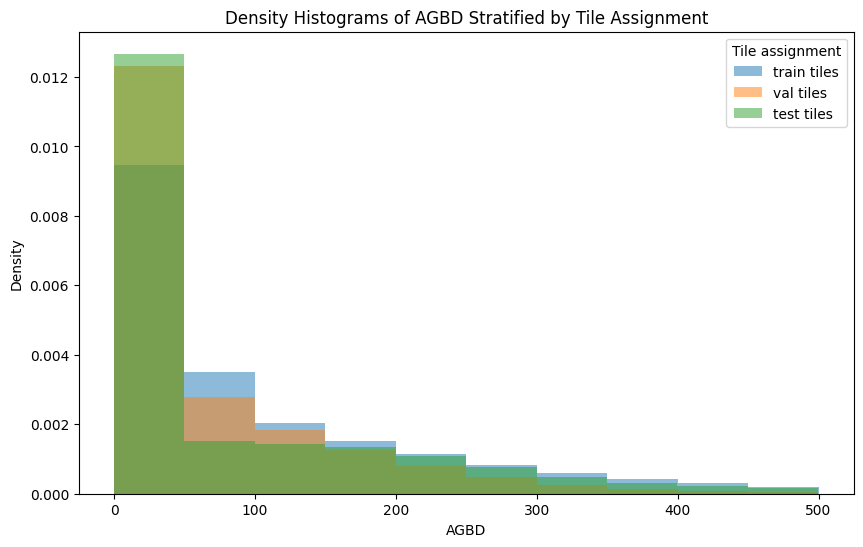

Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.6462926302528569, test = 0.20950394954596852, val = 0.1442034202011745
Coloured tiles


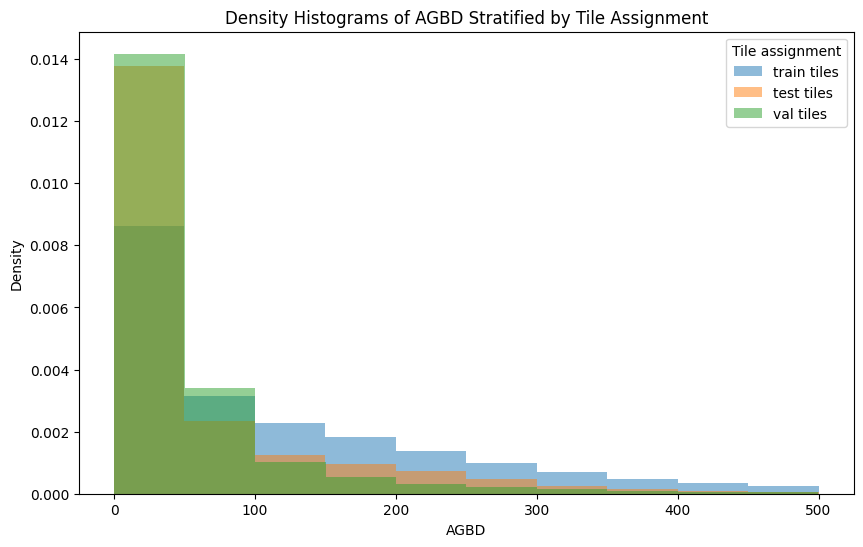

Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.648221432791208, test = 0.20639165254950134, val = 0.14538691465929052
Coloured tiles


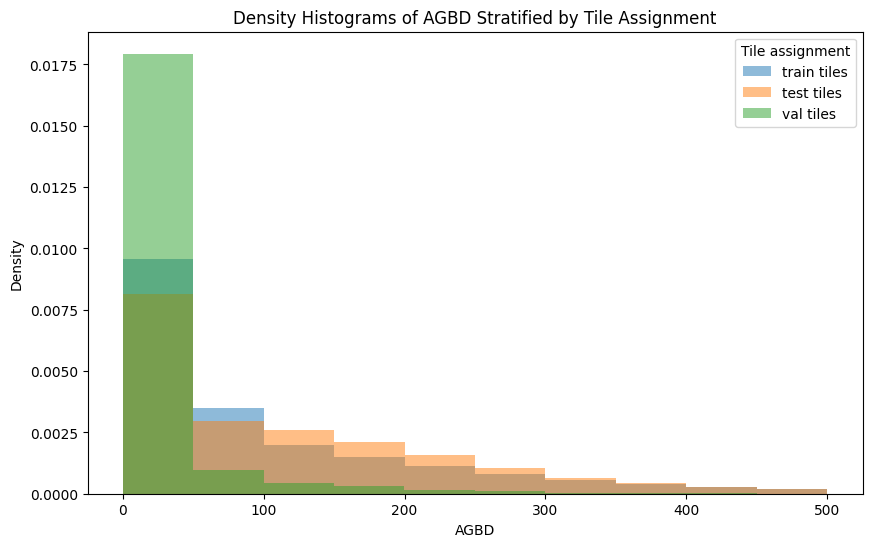

Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.6412133850288927, test = 0.20762307364269814, val = 0.15116354132840895
Coloured tiles


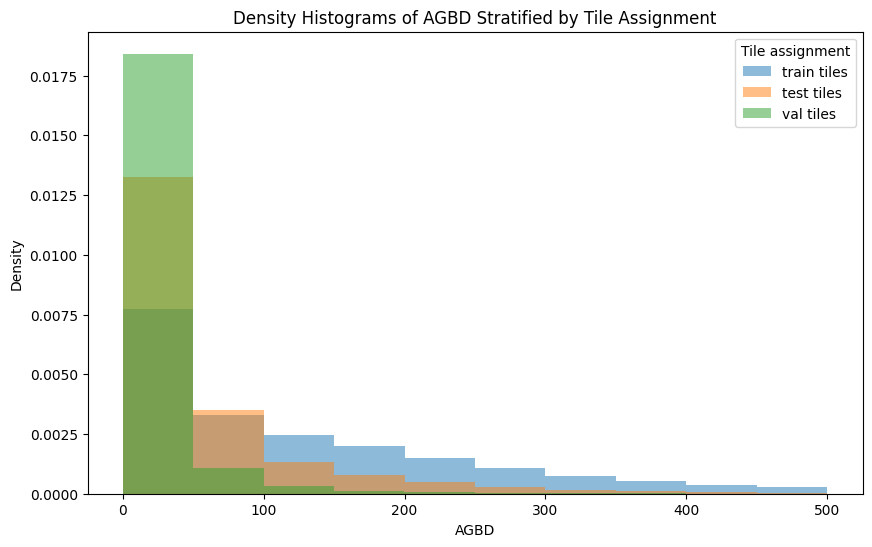

Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.6579661892260922, test = 0.19145321382321526, val = 0.15058059695069229
Coloured tiles


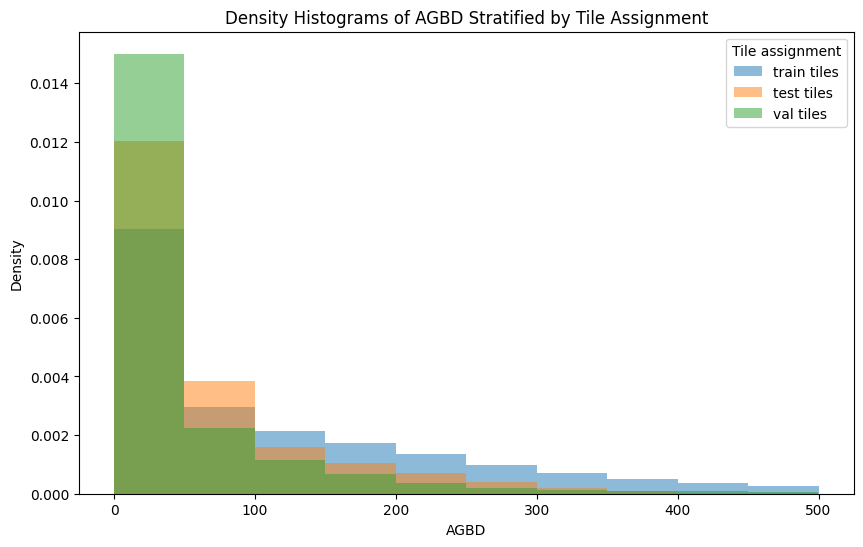

Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.6370124687498776, test = 0.2080661504935465, val = 0.15492138075657572
Coloured tiles


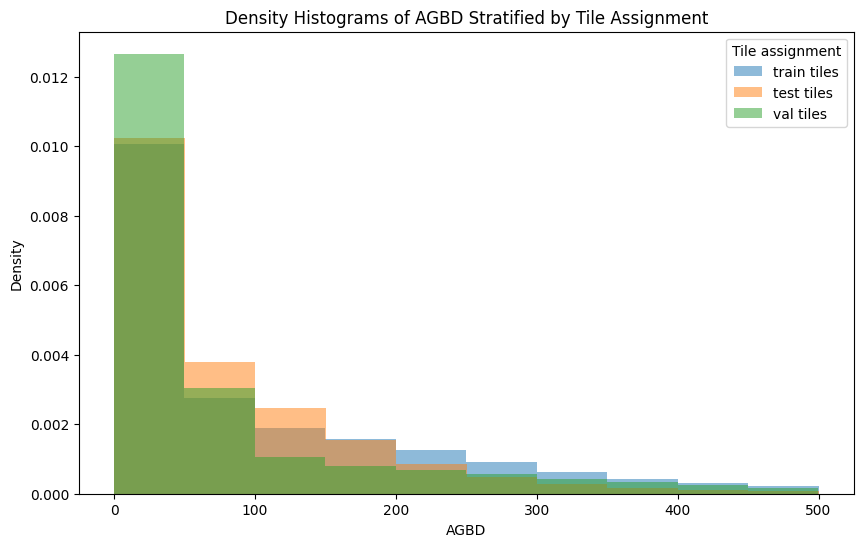

Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.6602480839126913, test = 0.1969051130872969, val = 0.14284680300001174
Coloured tiles


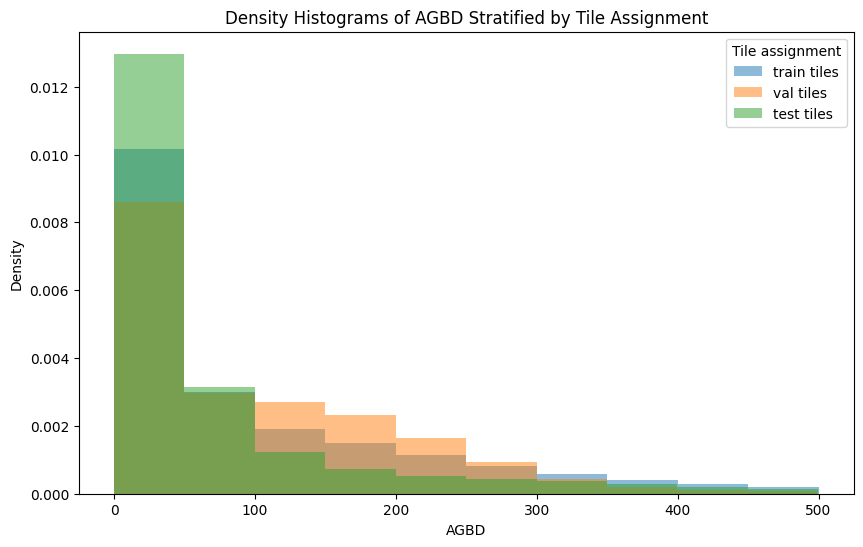

Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.6535090121635844, test = 0.20618136221190225, val = 0.1403096256245134
Coloured tiles


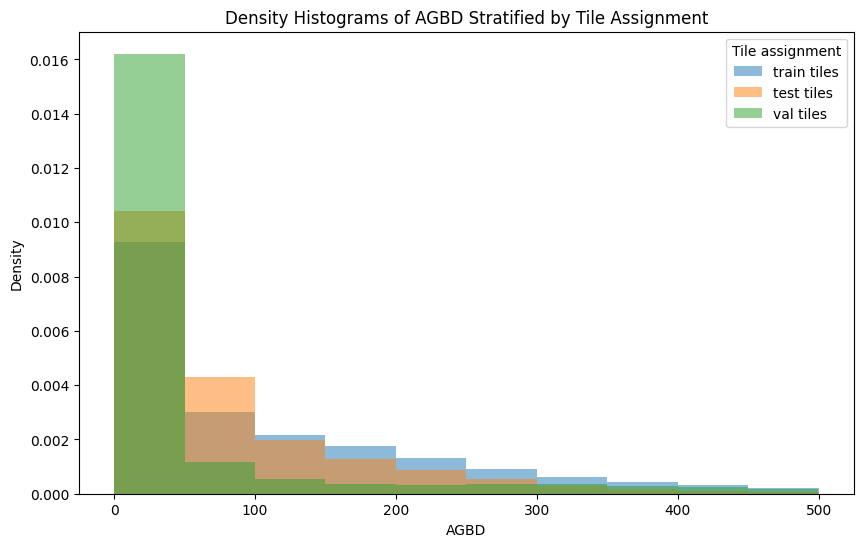

Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.6433397626751278, test = 0.20042820981302742, val = 0.15623202751184473
Coloured tiles


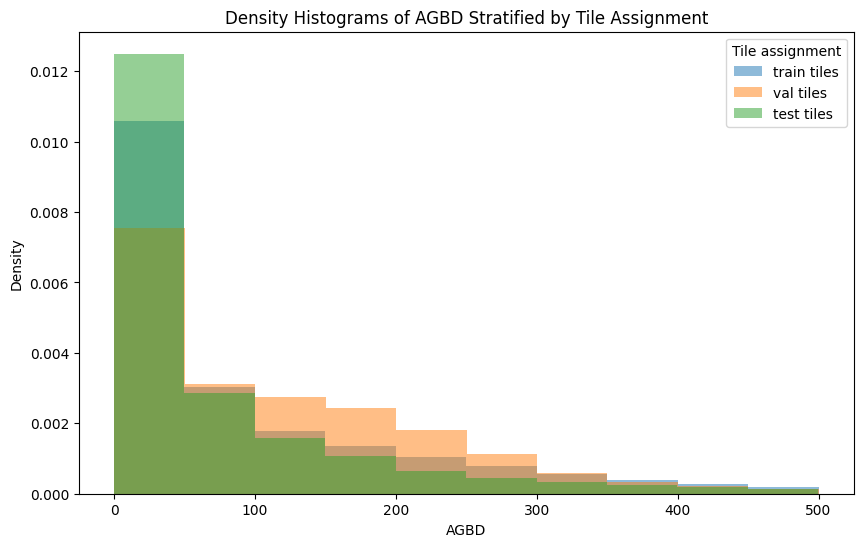

Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.6656765089065293, test = 0.19204104867389932, val = 0.14228244241957128
Coloured tiles


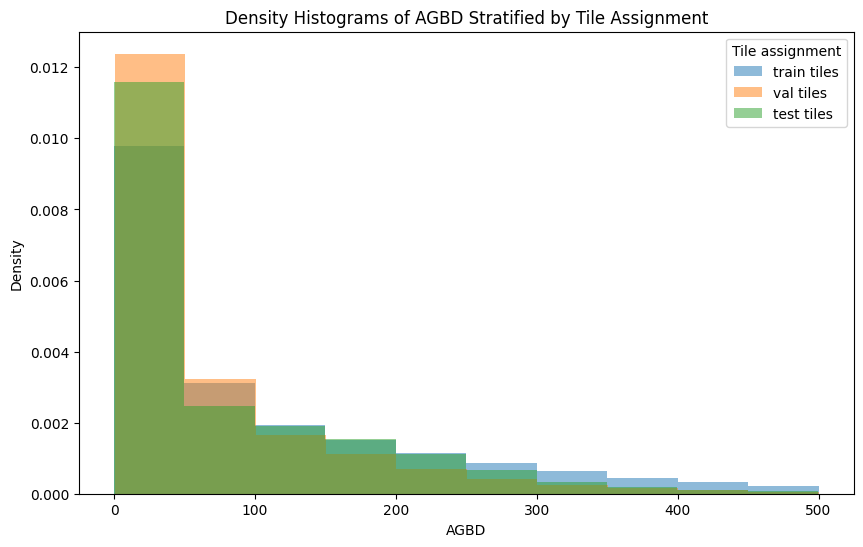

Compared agbd distributions!


In [9]:
os.chdir(r"C:\Users\nial\Documents\GitHub\Master-Thesis")
%run custom_ttv_split.py

### Benchmark against TORRENT method

Determine inliers with TORRENT

In [ ]:
x       = df_satellite_band[['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']]
y       = df_satellite_band[['agbd']]
a       = 4000 / len(df_satellite_band) # fraction of inliers

x       = x.to_numpy()
y       = y.to_numpy()

torrent = Torrent(a, fit_intercept=True)
torrent.fit(x,y)

Fit model to chosen inliers

In [ ]:
X       = x[torrent.inliers]
Y       = y[torrent.inliers]
model   = sm.OLS(Y, X).fit()

Predict on test set

In [ ]:
model.predict()

### Synthetic Beta Updates

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Score improved at timestep 0!
PFT class 2 sampled
Score worsened at timestep 1!
PFT class 1 sampled
Score worsened at timestep 2!
PFT class 2 sampled
Score improved at timestep 3!
PFT class 1 sampled
Score improved at timestep 4!
PFT class 2 sampled
Score worsened at timestep 5!
PFT class 2 sampled
Score improved at timestep 6!
PFT class 2 sampled
Score worsened at timestep 7!
PFT class 2 sampled
Score worsened at timestep 8!
PFT class 2 sampled
Score improved at timestep 9!
PFT class 1 sampled
Score improved at timestep 10!
PFT class 2 sampled
Score worsened at timestep 11!
PFT class 2 sampled
Score worsened at timestep 12!
PFT class 2 sampled
Score worsened at timestep 13!
PFT class 1 sampled
Score improved at timestep 14!
PFT class 1 sampled
Score worsened at timestep 15!
PFT class 2 sampled
Score worsened at timestep 16!
PFT class 2 sampled
Score improved at timestep 17!
PFT class 1 sampled
Score worsened at timestep 18!
PFT class 1 sampled
Score improved at timestep 19!
PFT class 

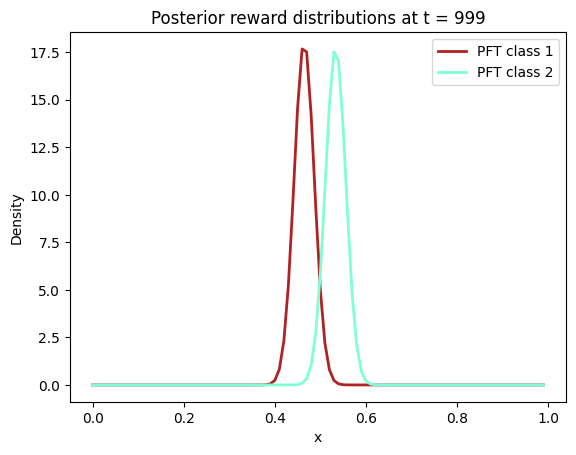

Score worsened at timestep 999!
PFT class 2 sampled


In [13]:
alphas                      = [1] * 2
betas                       = [1] * 2
labels                      = ['PFT class 1', 'PFT class 2']
colours                     = ['firebrick', 'aquamarine']
prev_score                  = 1
x                           = np.arange(100) / 100

for t in range(0,1000):
    
    if t == 999:
        plt.clf()
        plt.xlabel("x")
        plt.ylabel("Density")
        plt.legend(fontsize='small')
        plt.title(f"Posterior reward distributions at t = {t}")
    
        for i, _ in enumerate(labels):
            y                   = beta.pdf(x, a=alphas[i], b=betas[i])
            plt.plot(x,y,ls='-', linewidth=2, label=labels[i], color=colours[i])

        plt.legend()
        plt.show()
    
    pft_class               = np.random.choice([0,1])
    current_score           = np.random.uniform(0,1)
    
    if pft_class == 1:
        current_score       = current_score * 0.8

    if prev_score > current_score:

        print(f"Score improved at timestep {t}!")
        print(f"{labels[pft_class]} sampled")

        alphas[pft_class]   = alphas[pft_class] + 1
    
    else:

        print(f"Score worsened at timestep {t}!")
        print(f"{labels[pft_class]} sampled")

        betas[pft_class]    = betas[pft_class] + 1
        
    prev_score              = current_score



### Test the agent on `df_ghana`

Load `df_ghana`

In [ ]:
dtypes = {
     'pft_class': 'category'
    ,'leaf_off_f': 'category'
    ,'urban_prop': 'int64'
    ,'agbd': 'float64'
    ,'agbd_se': 'float64'
    ,'beam': 'category'
    ,'selected_a': 'category'
    ,'sensitivit': 'float64'
    ,'solar_elev': 'float64'
    ,'rh98': 'float64'
    ,'date': 'int64'
    ,'lat_cos': 'float64'
    ,'lat_sin': 'float64'
    ,'lon_cos': 'float64'
    ,'lon_sin': 'float64'
    ,'geometry': 'object'
}

df_ghana = pd.read_csv("df_ghana.csv", dtype=dtypes)

Benchmarking run 4


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 5


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 1


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 2


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 3


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 4


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 5


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


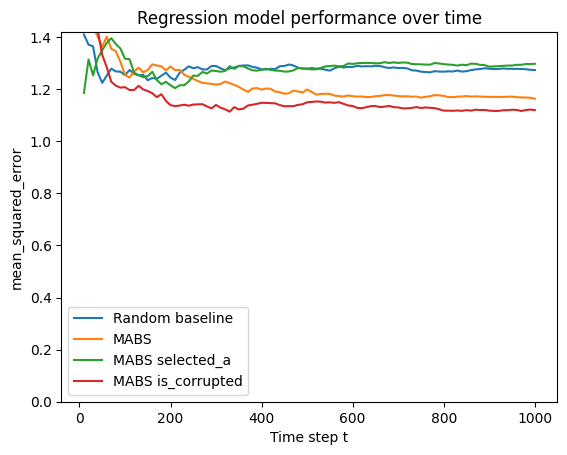

In [69]:
features_ghana  = {'selected_a':None}
x               = 'rh98'
y               = 'agbd'

crafty_boi = crafty_bandit(df_ghana, x=x\
                , y=y, features=features_ghana, T=1000, batch_size=1\
                , frac_train=0.8, frac_test=0.18, frac_val=0.02, test_freq=10, p_corrupt=0.1)

crafty_boi.benchmark_MABS(5)

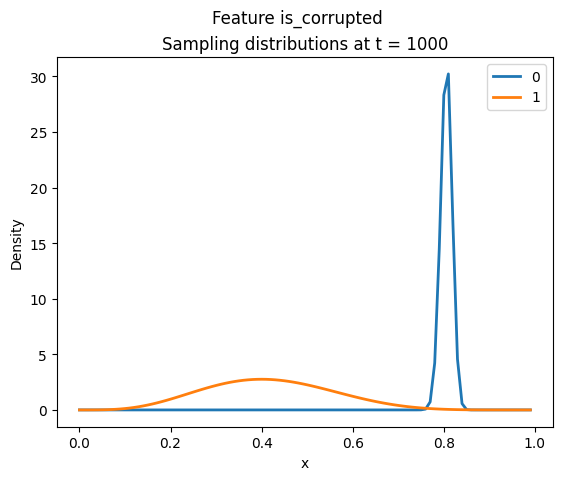

In [70]:
crafty_boi.plot_beta_dist('is_corrupted')

Summary: the agent performs as well as randomly selecting datapoints for the features tested. This is hardly surprising though. In simple linear regression, the model class considered is small.

In [ ]:
features = {'beam':None, 'selected_a':None}
bandit_boi = bandit(df_ghana, x='rh98', y='agbd', features=features, T=500, batch_size=1)
bandit_boi.benchmark_MABS(n_runs=10)

In [ ]:
features = {'beam':None, 'selected_a':None}
bandit_gal = bandit(df_ghana, x='rh98', y='agbd', features=features, T=500, batch_size=1)
bandit_gal.benchmark_MABS(n_runs=3)

In [ ]:
test_list = [x for x in range(51)]
test_list[10::10]

In [ ]:
features = {'beam':None, 'selected_a':None}
bandit_kid = bandit(df_ghana, x="rh98", y="agbd", features=features, T=50, batch_size=1)
bandit_kid.benchmark_MABS(n_runs=1)

Load previous bandit

In [ ]:
with open('bandit_boi.pkl', 'rb') as file:
    bandit_boi = pkl.load(file)

### Test the agent on `Appliances Energy Prediction`

We will test the agent on another dataset, `Appliances Energy Production`. The dataset consists of 19,000 measurements of household energy consumption, temperature and humidity conditions, co-located with meteorological variables. Our objective is to predict energy usage given the environmental variables.


In [ ]:
def get_df_energy():
    """
    Quick function to load & preprocess the appliances energy data.
    """
    # fetch dataset 
    appliances_energy_prediction = fetch_ucirepo(id=374)
    df_energy = appliances_energy_prediction.data['original']

    df_energy['date']       = pd.to_datetime(df_energy['date'], format='%Y-%m-%d%H:%M:%S')
    df_energy['month']      = df_energy['date'].dt.month
    # df_energy['month']      = df_energy['month'].astype('category')
    df_energy['lights']     = df_energy['lights'].astype('category')

    # difference between outside and inside temperature is a relevant variable

    df_energy['T_inside']   = df_energy.apply(lambda row: np.mean([row['T1'], row['T2'], row['T3'], row['T4'],\
                                                                   row['T5'], row['T7'], row['T8'], row['T9']])\
                                                                   , axis=1)

    df_energy['heating']    = df_energy['T_inside'] - df_energy['T6']

    df_energy['humid_in']   = df_energy.apply(lambda row: np.mean([row['RH_1'], row['RH_2'], row['RH_3'], row['RH_4'],\
                                                                   row['RH_5'], row['RH_7'], row['RH_8'], row['RH_9']])\
                                                                   , axis=1)

    df_energy['humid_diff'] = df_energy['humid_in'] - df_energy['RH_6']

    return df_energy

In [ ]:
df_energy = get_df_energy()
df_energy.columns

Column `Appliances` is the response variable (energy use in Wh). `TX` and `RHX` are temperature and relative humidity metrics for room `X`, respectively, while `lights` is the energy use of light fixtures in the house (Wh). The rest of the variables are meteorological measurements from a nearby weather station. A priori, I would expect that the `lights` variable is relevant for determining clusters, while `T_out` is a relevant predictor. 

In [ ]:
features_energy = {'month':None}

bandit_energy   = bandit(df_energy, x=['heating', 'lights', 'Press_mm_hg', 'humid_diff', 'Windspeed', 'Visibility', 'Tdewpoint']\
                        , y='Appliances', features=features_energy, T=1000, frac_train=0.8, frac_val=0.02, frac_test=0.18)

We model the appliances energy consumption using temperatures from most rooms and the relative humidity in the bathroom.

In [ ]:
bandit_energy.benchmark_MABS(n_runs=10)

Perhaps picking observations based on the month in which they are made is not a useful strategy...

In [ ]:
features_energy = {'lights':None}

bandit_energy   = bandit(df_energy, x=['heating', 'humid_diff']\
                        , y='Appliances', features=features_energy, T=1000, frac_train=0.8, frac_val=0.02, frac_test=0.18)

In [ ]:
bandit_energy.benchmark_MABS(n_runs=10)

What is R2 with model for heating and lights, no selection?

In [ ]:
appliances_energy_prediction = fetch_ucirepo(id=374)
df_orig = appliances_energy_prediction.data['original']

In [ ]:
linear_model = LinearRegression()

In [ ]:
linear_model.fit(df_orig[[col for col in df_orig.columns if col not in ['date', 'Appliances']]], df_orig['Appliances'])

In [ ]:
y_pred = linear_model.predict(df_orig[[col for col in df_orig.columns if col not in ['date', 'Appliances']]])
r2      = r2_score(df_orig['Appliances'], y_pred)
var_exp = explained_variance_score(df_orig['Appliances'], y_pred)
r2, var_exp

With all predictors and whole dataset, $R^2 = 0.16$, suggesting that this prediction task may be too difficult for separating good and bad models :/

### Data Loading

Manually set `dtypes`

In [ ]:
dtypes = {
     'pft_class': 'category'
    ,'region_cla': 'category'
    ,'leaf_off_f': 'category'
    ,'urban_prop': 'int64'
    ,'agbd': 'float64'
    ,'agbd_se': 'float64'
    ,'beam': 'category'
    ,'elev_lowes': 'float64'
    ,'lat_lowest': 'float64'
    ,'lon_lowest': 'float64'
    ,'selected_a': 'category'
    ,'shot_numbe': 'int64'
    ,'sensitivit': 'float64'
    ,'solar_elev': 'float64'
    ,'rh98': 'float64'
    ,'pattern': 'object'
    ,'doy_sin': 'float64'
    ,'doy_cos': 'float64'
    ,'date': 'int64'
    ,'lat_cos': 'float64'
    ,'lat_sin': 'float64'
    ,'lon_cos': 'float64'
    ,'lon_sin': 'float64'
    ,'pft_class_group': 'category'
    ,'geometry': 'object'
}

df_ghana_subsample = pd.read_csv('df_ghana_subsample.csv', dtype=dtypes)

Save `df_ghana`

In [ ]:
df_ghana = gpd.read_file("GEDI_Ghana.geojson"
                         , driver = 'GeoJSON'
                         , engine='pyogrio')

df_ghana = df_ghana[df_ghana['pft_class'] == 2]

cols_to_keep = ['pft_class', 'leaf_off_f','urban_prop','agbd','agbd_se', 'beam', 'selected_a', 'sensitivit'\
                     , 'solar_elev', 'rh98', 'date', 'lat_cos','lat_sin','lon_cos','lon_sin', 'geometry']

df_ghana = df_ghana[cols_to_keep]

df_ghana.to_csv("df_ghana.csv", index=False)

df_ghana.head(5)

### Test the agent on `Bike Sharing Data`

We have 17379 observations corresponding to hourly measurements of weather and a variable `cnt` indicating the number of bikes rented.

In [ ]:
def classify_day(row):
    """
    Simplify classification of DOTW
    """
    if row['holiday'] == 1: return 'holiday'
    elif row['weekday'] in [0,6]: return 'weekend'
    else: return 'work day'

In [ ]:
def classify_hr(row):
    """
    Simplify classification of hr
    """
    if row['hr'] in [8,16,17,18,19]: return 'rush hour'
    elif row['hr'] in [7, 9, 10, 11, 12, 13, 14, 15, 20]: return 'day'
    else: return 'night'

In [ ]:
def get_df_bike():
    """
    Wrapper to fetch and preprocess the bike sharing data.
    """
    bike                = fetch_ucirepo(id=275)
    df_bike             = bike.data['original']

    # simplify classificaitons
    df_bike['day_type'] = df_bike.apply(lambda row: classify_day(row), axis=1)
    df_bike['hr_type']  = df_bike.apply(lambda row: classify_hr(row), axis=1)

    # cat cols
    cat_cols            = ['day_type', 'hr_type', 'season', 'weathersit']
    df_bike[cat_cols]   = df_bike[cat_cols].astype('category')
    
    # drop redundant columns
    df_bike.drop(columns=['casual', 'registered', 'temp', 'holiday', 'weekday', 'workingday', 'hr', 'mnth', 'dteday', 'instant'], inplace=True)

    return df_bike, cat_cols

In [ ]:
average_cnt_by_hr = df_bike.groupby('hr')['cnt'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_cnt_by_hr.index, average_cnt_by_hr.values, marker='o', linestyle='-', color='b')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Count')
plt.title('Average Count by Hour of the Day')
plt.grid(True)
plt.xticks(range(24))  # Assuming hr is in 24-hour format
plt.show()

In [ ]:
df_encoded.head()

In [ ]:
df_bike.head()

In [ ]:
df_bike, cat_cols = get_df_bike()
df_encoded        = pd.get_dummies(df_bike, columns=['season', 'yr', 'weathersit'], drop_first=True)

bike_features = {'day_type': None, 'hr_type': None}
x             = [col for col in df_encoded.columns if col not in ['cnt', 'day_type', 'hr_type']]


# bandit_bike = bandit(df_encoded, x=x\
#                , y='cnt', features= bike_features, T=1000, batch_size=1\
#                , frac_train=0.8, frac_test=0.18, frac_val=0.02, test_freq=10)

crafty_bandit_bike = crafty_bandit(df_encoded, x=x\
                , y='cnt', features= bike_features, T=1000, batch_size=1\
                , frac_train=0.8, frac_test=0.18, frac_val=0.02, test_freq=10, p_corrupt=0.1)

In [ ]:
crafty_bandit_bike.features

In [ ]:
crafty_bandit_bike.benchmark_MABS(n_runs=3)

In [ ]:
crafty_bandit_bike.plot_beta_dist('is_corrupted')

In [ ]:
bandit_bike.benchmark_MABS(n_runs=10)

In [ ]:
len(y_hat)

In [ ]:
y       = np.array([3, 3])
y_hat   = np.array([6, 7])

mean_absolute_percentage_error(y, y_hat)

In [ ]:
bandit_mse.reset()
bandit_mse.benchmark_MABS(n_runs=10)

In [ ]:
bandit_UTH.reset()
bandit_UTH.benchmark_MABS(n_runs=10)

In [ ]:
len(bandit_UTH.test_scores)

In [ ]:
bandit_UTH.plot_beta_dist('day_type')

In [ ]:
# LASSO
bike_bandit.benchmark_MABS(n_runs=10)

In [ ]:
# RIDGE

bike_bandit.benchmark_MABS(n_runs=10)

### Testing decorators

In [39]:
def decorator(lazy):

    def actual_decorator(cls):
        
        parent = Test_1 if lazy else Test_2

        # Define a new class that inherits from the chosen parent class
        class WrappedClass(parent, cls):
            pass
        
        return WrappedClass
    return actual_decorator

In [34]:
class Test_1():
    
    def print_message(self):
        print("Reporting from Test_1() class")

class Test_2():
    
    def print_message(self):
        print("Reporting from Test_2() class")

In [44]:
@decorator(lazy=False)
class Test_3():

    pass

In [45]:
t3 = Test_3()
t3.print_message()

Reporting from Test_2() class


### Making Satellite Band DataFrame

Load features and labels

In [ ]:
suffix          = "_2020-vghana.csv"

test_features   = pd.read_csv("test_features" + suffix)
test_labels     = pd.read_csv("test_labels" + suffix)
train_features  = pd.read_csv("train_features" + suffix)
train_labels    = pd.read_csv("train_labels" + suffix)
val_features    = pd.read_csv("val_features" + suffix)
val_labels      = pd.read_csv("val_labels" + suffix)

Merge into one dataset

In [6]:
test_features['agbd']           = test_labels['agbd']
train_features['agbd']          = train_labels['agbd']
val_features['agbd']            = val_labels['agbd']

test_features['identity']       = 'test'
train_features['identity']      = 'train'
val_features['identity']        = 'val'

df_satellite_band               = pd.concat([train_features, val_features, test_features], ignore_index=True)
df_satellite_band.to_csv("df_satellite_band.csv", index=False)

NameError: name 'test_labels' is not defined